## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Matplotlib is building the font cache; this may take a moment.


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-12-26 21:08:15.958202


{1: 24.2,
 5: 25.4,
 10: 26.1,
 20: 26.9,
 30: 27.8,
 40: 29.2,
 50: 30.9,
 60: 32.6,
 70: 34.6,
 80: 36.8,
 90: 40.2,
 95: 43.1,
 99: 49.70100000000002}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2025-01-08 14:10:01.115885


{1: 8.5,
 5: 8.6,
 10: 8.7,
 20: 8.9,
 30: 9.0,
 40: 9.1,
 50: 9.1,
 60: 9.2,
 70: 9.3,
 80: 9.5,
 90: 9.7,
 95: 9.8,
 99: 10.2}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2025-01-23 12:52:18.919869


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev3)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49) (version 0.28-dev3)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49) (version 0.28-dev3)}}

In [6]:
def wildeford_max_gdp_frac():
    gdp_frac = sq.mixture([[0.9, sq.lognorm(1/500, 1/100)],
                           [0.1, sq.lognorm(1/100, 1/20)]])
    percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
    percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)
    compute_frac = gdp_frac * percent_spent_on_compute * percent_spent_on_largest_model
    return {'total_frac': gdp_frac, 'compute_frac': compute_frac}


base_flop_per_dollar = sq.lognorm(18.2, 19.4) # https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
# I'd use 1.43e18 FLOP/$ if renting cloud compute for training (significantly higher for serving a product, and significantly lower if using your own compute -- but then the number depends on how long you amortize it over).
# Source: If renting cloud compute, pricing seems to be $1.89-2.40 per H100 hour. (Jack Clark says $2 with bulk discounts.) Going with $2/hr, with the H100's 1.98e15 FLOP/s (FP8) and assuming 40% utilization (for training), that's 1.98e15*.4*60*60/2 = 1.43e18 FLOP/$.
# https://jack-clark.net/2024/03/28/what-does-1025-versus-1026-mean/ and https://gpus.llm-utils.org/h100-gpu-cloud-availability-and-pricing/
flop_frontier_penalty = sq.norm(0, 1)

# https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': np.array(tai_flop_size),
             'algo_doubling_rate_max': sq.lognorm(0.5, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': base_flop_per_dollar - flop_frontier_penalty,
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': np.array(initial_pay),
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'],
             'spend_doubling_time': sq.lognorm(0.5, 2, lclip=0.1),
             'nonscaling_delay': delay }

variables

{'initial_gdp': <Distribution> 23320000000000.0 * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) (version 0.28),
 'tai_flop_size': array([27.2, 24.5, 34.5, ..., 29.7, 27.3, 29.5]),
 'algo_doubling_rate_max': <Distribution> lognorm(lognorm_mean=1.42, lognorm_sd=0.83, norm_mean=0.2, norm_sd=0.54) (version 0.28),
 'algo_doubling_rate_min': <Distribution> lognorm(lognorm_mean=1.09, lognorm_sd=0.48, norm_mean=0.0, norm_sd=0.42) (version 0.28),
 'min_reduction': 2,
 'max_reduction': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28),
 'initial_flop_per_dollar': <Distribution> lognorm(lognorm_mean=18.79, lognorm_sd=0.36, norm_mean=2.93, norm_sd=0.02) - norm(mean=0.5, sd=0.3) (version 0.28),
 'flop_halving_rate': <Distribution> norm(mean=2.5, sd=0.3) (version 0.28),
 'max_

## GDP Frac

### GDP

In [7]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000)
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '24.8 trillion',
 5: '24.9 trillion',
 10: '24.9 trillion',
 20: '25.0 trillion',
 30: '25.0 trillion',
 40: '25.1 trillion',
 50: '25.1 trillion',
 60: '25.1 trillion',
 70: '25.2 trillion',
 80: '25.2 trillion',
 90: '25.3 trillion',
 95: '25.3 trillion',
 99: '25.4 trillion'}

#### Total % of GDP spent on entire project

In [8]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 18712.51it/s]


{1: 0.00151,
 5: 0.00207,
 10: 0.00247,
 20: 0.00312,
 30: 0.00368,
 40: 0.00426,
 50: 0.00488,
 60: 0.00563,
 70: 0.00671,
 80: 0.00821,
 90: 0.01383,
 95: 0.02429,
 99: 0.04553}

In [9]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.151%',
 5: '0.207%',
 10: '0.247%',
 20: '0.312%',
 30: '0.368%',
 40: '0.426%',
 50: '0.488%',
 60: '0.563%',
 70: '0.671%',
 80: '0.821%',
 90: '1.383%',
 95: '2.429%',
 99: '4.553%'}

In [10]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '37.8 billion',
 5: '51.9 billion',
 10: '62.1 billion',
 20: '78.1 billion',
 30: '92.3 billion',
 40: '106.8 billion',
 50: '122.5 billion',
 60: '141.5 billion',
 70: '168.1 billion',
 80: '206.1 billion',
 90: '346.8 billion',
 95: '610.6 billion',
 99: '1.1 trillion'}

#### Total % of GDP spent on compute for largest model

In [11]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6071.32it/s]


{1: '0.001%',
 5: '0.004%',
 10: '0.006%',
 20: '0.011%',
 30: '0.017%',
 40: '0.027%',
 50: '0.038%',
 60: '0.056%',
 70: '0.084%',
 80: '0.137%',
 90: '0.257%',
 95: '0.396%',
 99: '1.058%'}

In [12]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.001%',
 5: '0.004%',
 10: '0.006%',
 20: '0.011%',
 30: '0.017%',
 40: '0.027%',
 50: '0.038%',
 60: '0.056%',
 70: '0.084%',
 80: '0.137%',
 90: '0.257%',
 95: '0.396%',
 99: '1.058%'}

In [13]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '366.3 million',
 5: '906.4 million',
 10: '1.4 billion',
 20: '2.7 billion',
 30: '4.4 billion',
 40: '6.7 billion',
 50: '9.7 billion',
 60: '14.0 billion',
 70: '21.0 billion',
 80: '34.3 billion',
 90: '64.5 billion',
 95: '99.6 billion',
 99: '265.1 billion'}

In [14]:
def model():
    frac = wildeford_max_gdp_frac()
    return frac['total_frac'] / frac['compute_frac']

sq.get_percentiles(sq.sample(model, verbose=True, n=5000), digits=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3639.10it/s]


{1: 0.4,
 5: 1.0,
 10: 1.8,
 20: 3.5,
 30: 5.9,
 40: 9.1,
 50: 13.6,
 60: 20.2,
 70: 30.5,
 80: 55.1,
 90: 110.0,
 95: 198.8,
 99: 643.4}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 33.2 log FLOP (~1.6 decillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~14.3 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.4 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~931.1 million).
* This doubles every 1.6 year to a max of 0.053714% of GDP (initially ~13.5 billion 2025$USD).
* GDP grows at a rate of 1.033x per year.
---
2025 - TAI takes 33.2 logFLOP which costs 14.0 log 2025$USD to buy vs. WTP at 8.9 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 33.0 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 9.1 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 32.7 logFLOP which costs 13.3 log 2025$USD to buy vs. WTP at 9.3 (buys 28.7 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 32.5 logFLOP which costs 13

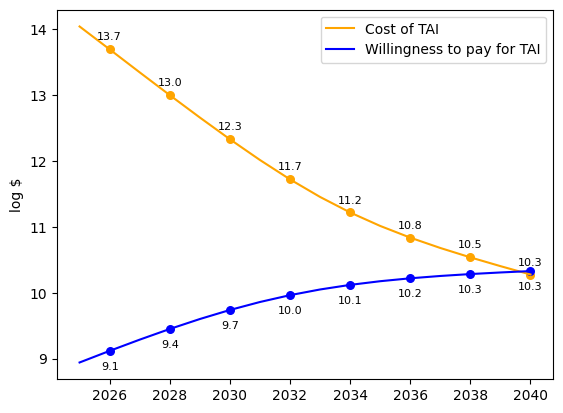



## SAMPLE RUN 2 ##

In this simulation:
* It takes 25.6 log FLOP (~39.8 septillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2025$USD.
* Every 3.2 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~2.0 billion).
* This doubles every 0.8 year to a max of 0.507471% of GDP (initially ~127.7 billion 2025$USD).
* GDP grows at a rate of 1.037x per year.
---
2025 - TAI takes 25.6 logFLOP which costs 7.1 log 2025$USD to buy vs. WTP at 9.3 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 3 more

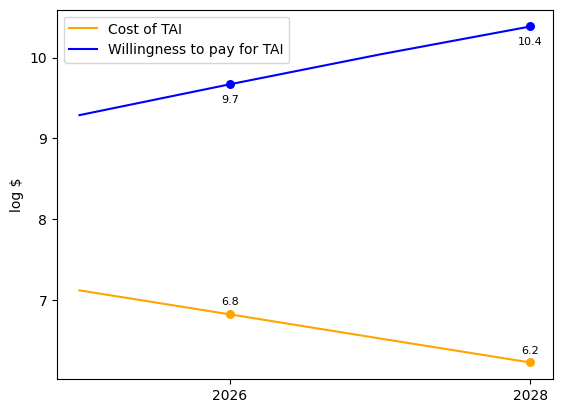



## SAMPLE RUN 3 ##

In this simulation:
* It takes 31.5 log FLOP (~31.6 nonillion) for transformative capabilities.
* Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.7 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~736.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~957.3 million).
* This doubles every 0.5 year to a max of 0.090304% of GDP (initially ~22.4 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 31.5 logFLOP which costs 13.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 31.4 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 9.5 (buys 27.8 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 31.3 logFLOP which costs 12.9 log 2025$USD to buy vs. WTP at 9.9 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 31.2 logFLOP which costs 

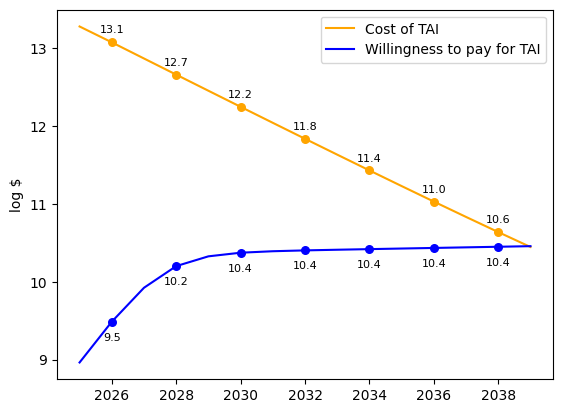



## RUN TIMELINES MODEL ##
Generating Bayes net with 12 cores...


10044it [00:11, 858.20it/s]                                                                                                                                                                                                                          


Shuffling data...
Writing data...
Waiting for other cores...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 855.50it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['1%: 2025',
 '2%: 2026',
 '3%: 2026',
 '4%: 2026',
 '5%: 2027',
 '10%: 2027',
 '15%: 2028',
 '20%: 2028',
 '25%: 2028',
 '35%: 2030',
 '50%: 2034',
 '60%: 2043',
 '75%: 2063',
 '80%: 2079',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['1%: 0 years from now',
 '2%: 1 years from now',
 '3%: 1 years from now',
 '4%: 1 years from now',
 '5%: 2 years from now',
 '10%: 2 years from now',
 '15%: 3 years from now',
 '20%: 3 years from now',
 '25%: 3 years from now',
 '35%: 5 years from now',
 '50%: 9 years from now',
 '60%: 18 years from now',
 '75%: 38 years from now',
 '80%: 54 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 28 years from now)


## TAI ARRIVAL DATE BY BIN ##
2025-2026: 4.3%
2027-2029: 29.3%
2030-2034: 16.8%
2035-2039: 6.6%



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~25.9 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.2 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.8 trillion) 80% CI 13.4 (~26.2 trillion) - 13.4 (~27.4 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.4 trillion) 80% CI 13.4 (~26.7 trillion) - 13.4 (~28.2 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.0 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~29.0 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.7 trillion) 80% CI 13.4 (~27.6 trillion) - 13.5 (~29.8 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.3 trillion) 80% CI 13.4 (~28.0 trillion) - 13.5 (~30.6 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~30.0 trillion) 80% CI 13.5 (~28.5 trillion) - 13.5 (~31.5 trillion)
Year: 2034 - GDP log 2024$USD 13.

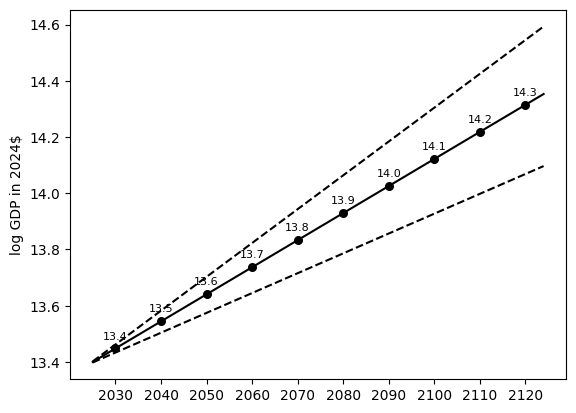

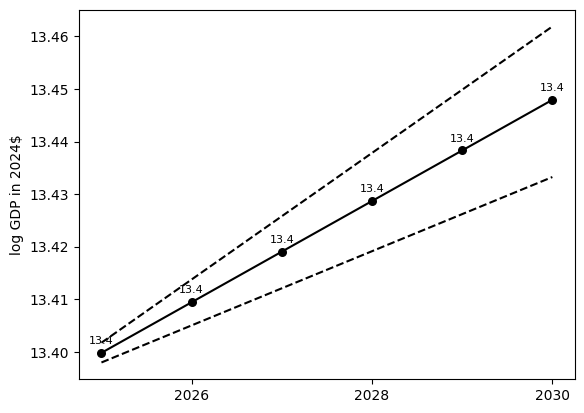



## Willingness to Pay Over Time (Total infrastructure) ##
Year: 2025 - willingness log 2024$USD per year for total infrastructure 10.5 (~33.7 billion) 80% CI 9.8 (~6.2 billion) - 11.4 (~228.6 billion)
Year: 2026 - willingness log 2024$USD per year for total infrastructure 10.8 (~59.4 billion) 80% CI 10.1 (~12.1 billion) - 11.6 (~357.7 billion)
Year: 2027 - willingness log 2024$USD per year for total infrastructure 11.0 (~95.8 billion) 80% CI 10.3 (~19.0 billion) - 11.7 (~543.8 billion)
Year: 2028 - willingness log 2024$USD per year for total infrastructure 11.1 (~138.4 billion) 80% CI 10.4 (~24.3 billion) - 11.9 (~795.5 billion)
Year: 2029 - willingness log 2024$USD per year for total infrastructure 11.3 (~178.8 billion) 80% CI 10.4 (~27.3 billion) - 12.0 (~1.1 trillion)
Year: 2030 - willingness log 2024$USD per year for total infrastructure 11.3 (~210.9 billion) 80% CI 10.5 (~28.9 billion) - 12.2 (~1.5 trillion)
Year: 2031 - willingness log 2024$USD per year for total infrastructure

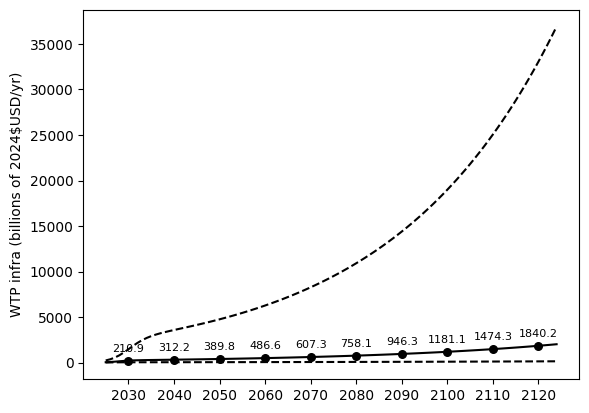

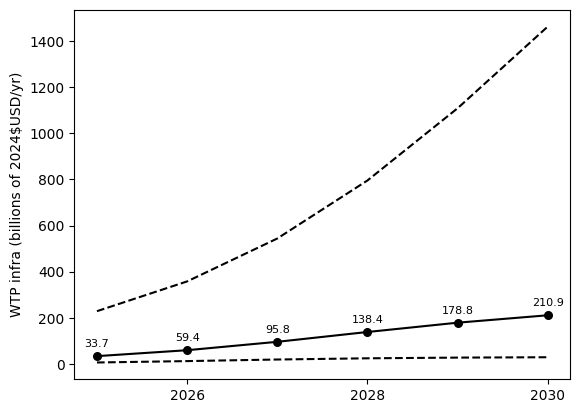



## Willingness to Pay Over Time (Largest single model) ##
Year: 2025 - willingness log 2024$USD per year for largest single model 9.1 (~1.3 billion) 80% CI 8.8 (~615.3 million) - 9.5 (~2.9 billion)
Year: 2026 - willingness log 2024$USD per year for largest single model 9.4 (~2.4 billion) 80% CI 9.1 (~1.2 billion) - 9.7 (~4.5 billion)
Year: 2027 - willingness log 2024$USD per year for largest single model 9.6 (~3.8 billion) 80% CI 9.3 (~1.9 billion) - 9.8 (~6.8 billion)
Year: 2028 - willingness log 2024$USD per year for largest single model 9.7 (~5.5 billion) 80% CI 9.4 (~2.4 billion) - 10.0 (~9.9 billion)
Year: 2029 - willingness log 2024$USD per year for largest single model 9.9 (~7.2 billion) 80% CI 9.4 (~2.7 billion) - 10.1 (~13.9 billion)
Year: 2030 - willingness log 2024$USD per year for largest single model 9.9 (~8.4 billion) 80% CI 9.5 (~2.9 billion) - 10.3 (~18.3 billion)
Year: 2031 - willingness log 2024$USD per year for largest single model 10.0 (~9.4 billion) 80% CI 9.5 (~

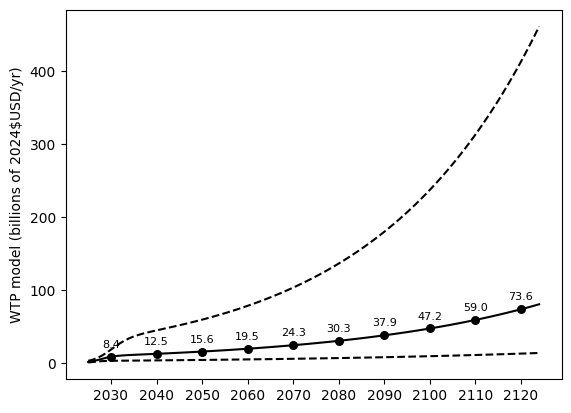

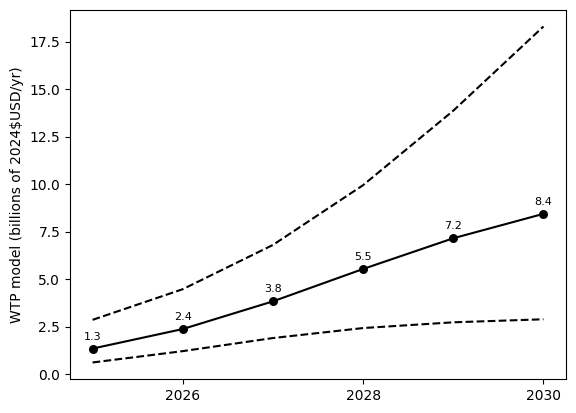



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 30.8 (~7.1 nonillion) 80% CI 26.9 (~794.3 septillion) - 36.6 (~4.0 thousand decillion)
Year: 2026 - logFLOP needed for TAI 30.6 (~3.6 nonillion) 80% CI 26.5 (~338.4 septillion) - 36.4 (~2.4 thousand decillion)
Year: 2027 - logFLOP needed for TAI 30.3 (~1.9 nonillion) 80% CI 26.2 (~145.4 septillion) - 36.2 (~1.5 thousand decillion)
Year: 2028 - logFLOP needed for TAI 30.0 (~965.6 octillion) 80% CI 25.8 (~65.1 septillion) - 36.0 (~901.6 decillion)
Year: 2029 - logFLOP needed for TAI 29.7 (~519.8 octillion) 80% CI 25.5 (~31.7 septillion) - 35.7 (~550.3 decillion)
Year: 2030 - logFLOP needed for TAI 29.5 (~296.1 octillion) 80% CI 25.3 (~17.8 septillion) - 35.5 (~336.5 decillion)
Year: 2031 - logFLOP needed for TAI 29.3 (~183.9 octillion) 80% CI 25.1 (~12.1 septillion) - 35.3 (~206.4 decillion)
Year: 2032 - logFLOP needed for TAI 29.1 (~127.5 octillion) 80% CI 25.0 (~9.7 septillion) - 35.

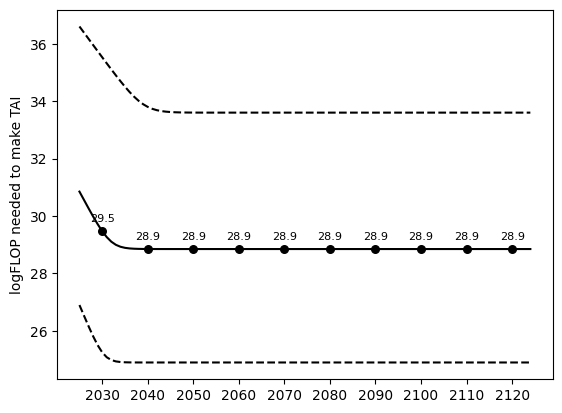

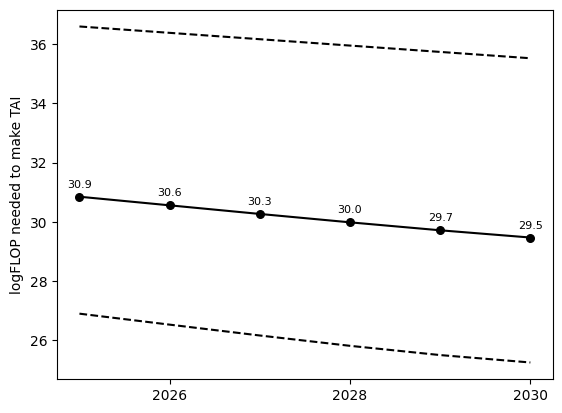



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.3 (~2.1 quintillion) 80% CI 17.9 (~774.9 quadrillion) - 18.8 (~6.0 quintillion)
Year: 2026 - logFLOP per 2024$1USD 18.4 (~2.8 quintillion) 80% CI 18.0 (~1.1 quintillion) - 18.9 (~7.7 quintillion)
Year: 2027 - logFLOP per 2024$1USD 18.6 (~3.6 quintillion) 80% CI 18.2 (~1.4 quintillion) - 19.0 (~9.9 quintillion)
Year: 2028 - logFLOP per 2024$1USD 18.7 (~4.8 quintillion) 80% CI 18.3 (~2.0 quintillion) - 19.1 (~12.7 quintillion)
Year: 2029 - logFLOP per 2024$1USD 18.8 (~6.3 quintillion) 80% CI 18.4 (~2.7 quintillion) - 19.2 (~16.3 quintillion)
Year: 2030 - logFLOP per 2024$1USD 18.9 (~8.3 quintillion) 80% CI 18.6 (~3.6 quintillion) - 19.3 (~21.0 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.0 (~11.0 quintillion) 80% CI 18.7 (~5.0 quintillion) - 19.4 (~27.0 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.2 (~14.4 quintillion) 80% CI 18.8 (~6.8 quintillion) - 19.5 (~34.7 quintillion)
Year: 2033 - lo

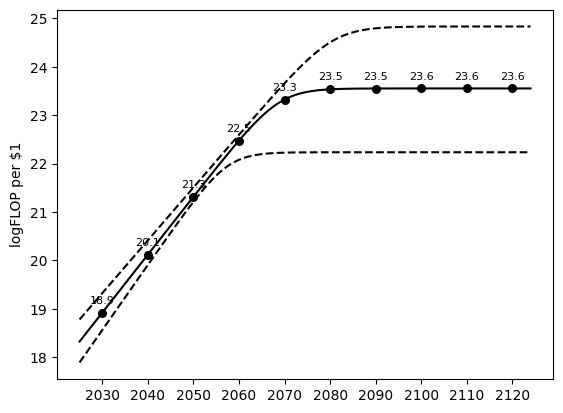

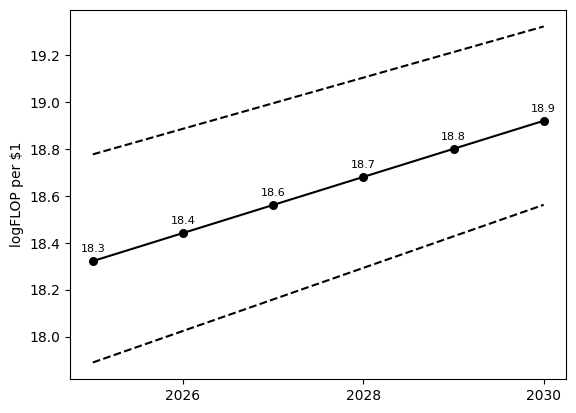



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

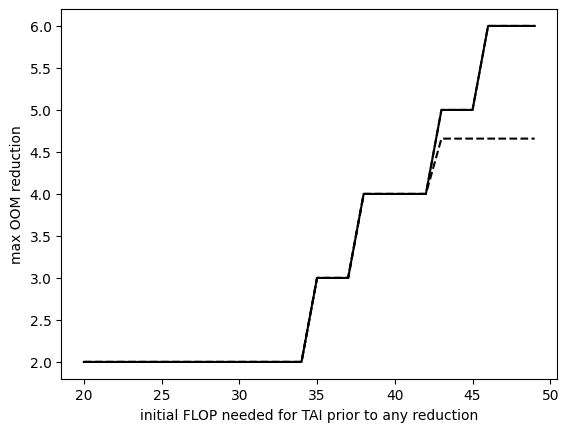



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.21yrs (80% CI: 1.92 to 1.92)
TAI log FLOP 21 -> algo doubling rate 1.21yrs (80% CI: 1.92 to 1.92)
TAI log FLOP 22 -> algo doubling rate 1.21yrs (80% CI: 1.92 to 1.92)
TAI log FLOP 23 -> algo doubling rate 1.21yrs (80% CI: 1.92 to 1.92)
TAI log FLOP 24 -> algo doubling rate 1.21yrs (80% CI: 1.92 to 1.92)
TAI log FLOP 25 -> algo doubling rate 1.21yrs (80% CI: 1.92 to 1.92)
TAI log FLOP 26 -> algo doubling rate 1.21yrs (80% CI: 1.92 to 1.92)
TAI log FLOP 27 -> algo doubling rate 1.21yrs (80% CI: 1.92 to 1.92)
TAI log FLOP 28 -> algo doubling rate 1.21yrs (80% CI: 1.92 to 1.92)
TAI log FLOP 29 -> algo doubling rate 1.21yrs (80% CI: 1.92 to 1.92)
TAI log FLOP 30 -> algo doubling rate 1.21yrs (80% CI: 1.92 to 1.92)
TAI log FLOP 31 -> algo doubling rate 1.01yrs (80% CI: 1.42 to 1.42)
TAI log FLOP 32 -> algo doubling rate 1.01yrs (80% CI: 0.92 to 0.92)
TAI log FLOP 33 -> algo doubling rate 1.01yrs (80%

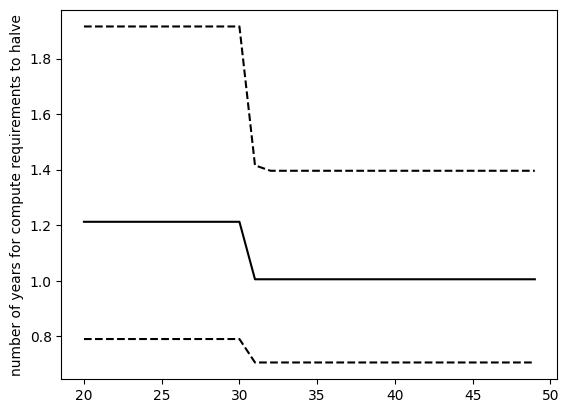



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 12.5 log 2024$USD to buy TAI (~3.4 trillion) 80% CI 9.0 (~1.0 billion) - 17.8 (~665.2 quadrillion)
Year: 2026 - 12.1 log 2024$USD to buy TAI (~1.3 trillion) 80% CI 8.5 (~320.4 million) - 17.5 (~315.5 quadrillion)
Year: 2027 - 11.7 log 2024$USD to buy TAI (~509.2 billion) 80% CI 8.0 (~101.0 million) - 17.2 (~149.5 quadrillion)
Year: 2028 - 11.3 log 2024$USD to buy TAI (~201.3 billion) 80% CI 7.5 (~33.2 million) - 16.9 (~70.9 quadrillion)
Year: 2029 - 10.9 log 2024$USD to buy TAI (~82.3 billion) 80% CI 7.1 (~11.9 million) - 16.5 (~33.7 quadrillion)
Year: 2030 - 10.6 log 2024$USD to buy TAI (~35.6 billion) 80% CI 6.7 (~4.9 million) - 16.2 (~16.0 quadrillion)
Year: 2031 - 10.2 log 2024$USD to buy TAI (~16.8 billion) 80% CI 6.4 (~2.4 million) - 15.9 (~7.6 quadrillion)
Year: 2032 - 9.9 log 2024$USD to buy TAI (~8.8 billion) 80% CI 6.2 (~1.4 million) - 15.6 (~3.7 quadrillion)
Year: 2033 - 

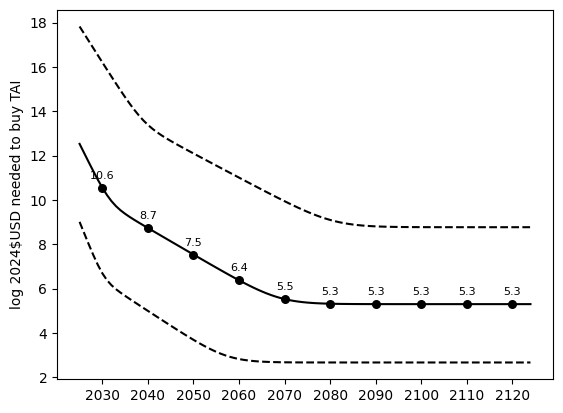

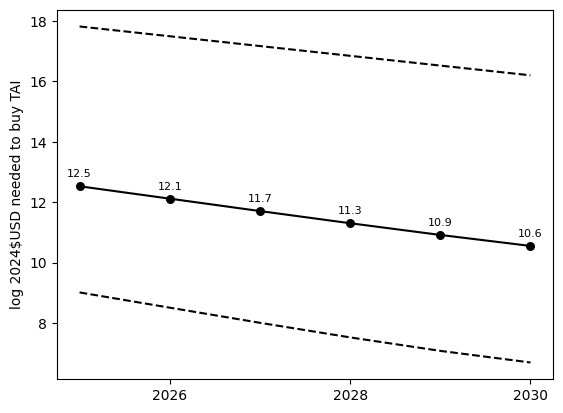



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.5 (~2.8 octillion) 80% CI 26.7 (~476.8 septillion) - 28.2 (~17.1 octillion)
Year: 2026 - max log FLOP 27.8 (~6.6 octillion) 80% CI 27.1 (~1.3 octillion) - 28.5 (~34.4 octillion)
Year: 2027 - max log FLOP 28.1 (~13.9 octillion) 80% CI 27.4 (~2.7 octillion) - 28.8 (~67.2 octillion)
Year: 2028 - max log FLOP 28.4 (~26.5 octillion) 80% CI 27.7 (~4.8 octillion) - 29.1 (~126.4 octillion)
Year: 2029 - max log FLOP 28.7 (~45.2 octillion) 80% CI 27.9 (~7.3 octillion) - 29.4 (~226.6 octillion)
Year: 2030 - max log FLOP 28.8 (~70.2 octillion) 80% CI 28.0 (~10.5 octillion) - 29.6 (~384.4 octillion)
Year: 2031 - max log FLOP 29.0 (~102.5 octillion) 80% CI 28.2 (~14.8 octillion) - 29.8 (~616.5 octillion)
Year: 2032 - max log FLOP 29.2 (~144.2 octillion) 80% CI 28.3 (~20.6 octillion) - 30.0 (~939.2 octillion)
Year: 2033 - max log FLOP 29.3 (~198.8 octillion) 80% CI 28.5 (~28.7 octillion) - 30.1 (~1.4 nonillion)
Year: 2034 - max log FLOP 29

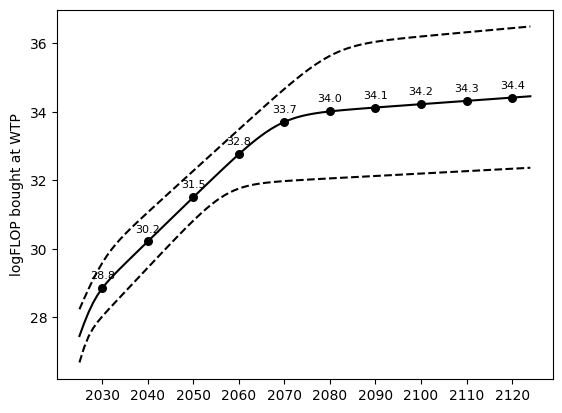

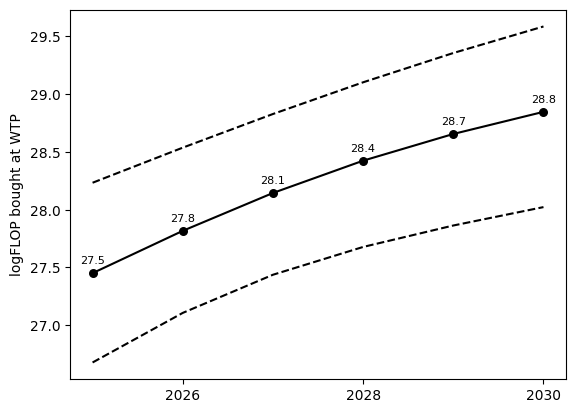



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.5 (~2.8 octillion) 80% CI 26.7 (~476.8 septillion) - 28.2 (~17.1 octillion)
Year: 2026 - max log effective 2024-FLOP 28.1 (~12.8 octillion) 80% CI 27.3 (~2.1 octillion) - 29.0 (~91.6 octillion)
Year: 2027 - max log effective 2024-FLOP 28.7 (~53.3 octillion) 80% CI 27.9 (~7.2 octillion) - 29.7 (~475.9 octillion)
Year: 2028 - max log effective 2024-FLOP 29.3 (~194.6 octillion) 80% CI 28.3 (~20.2 octillion) - 30.4 (~2.4 nonillion)
Year: 2029 - max log effective 2024-FLOP 29.8 (~615.2 octillion) 80% CI 28.7 (~49.6 octillion) - 31.0 (~11.0 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.2 (~1.7 nonillion) 80% CI 29.1 (~112.6 octillion) - 31.7 (~45.9 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.6 (~3.9 nonillion) 80% CI 29.4 (~243.6 octillion) - 32.2 (~164.0 nonillion)
Year: 2032 - max log effective 2024-FLOP 30.9 (~8.0 nonillion) 80% CI 29.

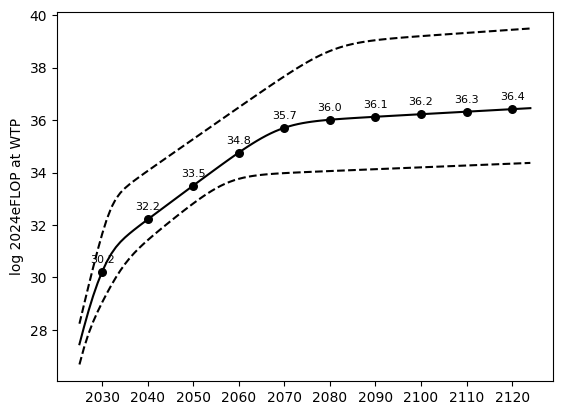

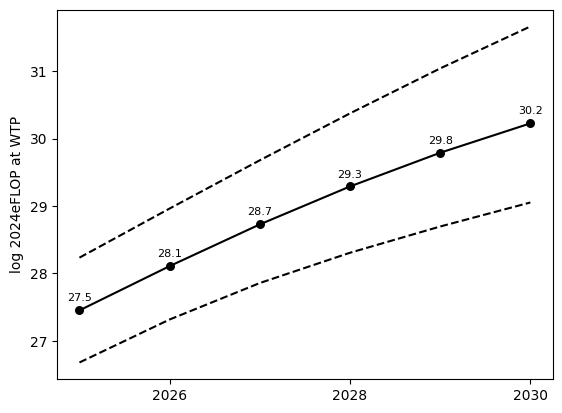


## TAI FLOP SIZE ##
{1: 24.1,
 5: 25.395,
 10: 26.2,
 20: 26.9,
 30: 27.9,
 40: 29.160000000000004,
 50: 30.85,
 60: 32.5,
 70: 34.3,
 80: 36.6,
 90: 40.5,
 95: 43.11499999999999,
 99: 48.803}


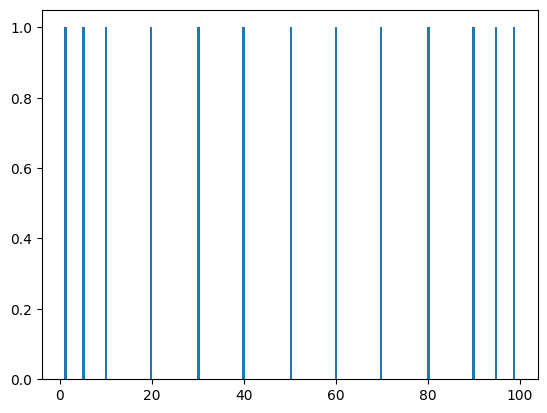



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.237070136778749,
 5: 3.169838499137418,
 10: 3.6518502939930957,
 20: 4.658431085761802,
 30: 5.216185549502704,
 40: 5.887956594856826,
 50: 6.614709391180256,
 60: 7.525228729066855,
 70: 8.590932375050702,
 80: 10.196697370908515,
 90: 12.646058635421628,
 95: 14.879303117064941,
 99: 20.66062391687997}


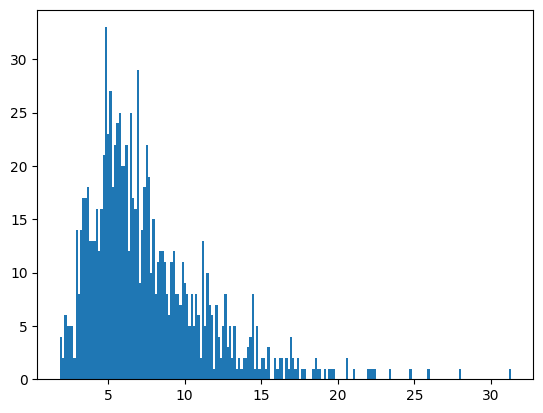



## MIN ALGO DOUBLING RATE ##
{1: 0.36585441904953486,
 5: 0.528675049407331,
 10: 0.5890000143184293,
 20: 0.7057916166573887,
 30: 0.7919120601979304,
 40: 0.9014583386547048,
 50: 1.0053394327682201,
 60: 1.0902130789941147,
 70: 1.218530308103815,
 80: 1.395974257847459,
 90: 1.687050916693299,
 95: 1.9632529250147255,
 99: 2.8515424639428244}


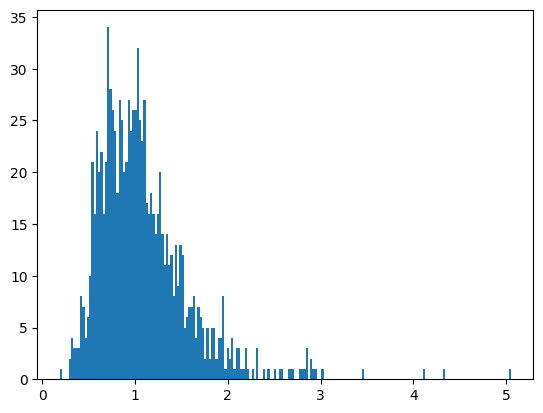



## MAX ALGO DOUBLING RATE ##
{1: 0.3532379612767511,
 5: 0.5083104802907353,
 10: 0.6075514214392176,
 20: 0.7902081013689075,
 30: 0.9248741005772422,
 40: 1.044675283945984,
 50: 1.212297701024749,
 60: 1.3828676064436727,
 70: 1.6128740175523608,
 80: 1.9154627338870118,
 90: 2.4314015344315503,
 95: 3.062766001569869,
 99: 4.3110670765311925}


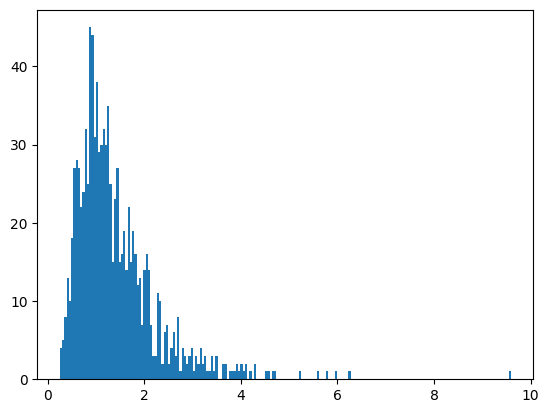



## INITIAL FLOP PER DOLLAR ##
{1: 17.187805228028306,
 5: 17.477270012513134,
 10: 17.651603396054632,
 20: 17.889239334649773,
 30: 18.06502215233612,
 40: 18.19626738769529,
 50: 18.321719034101555,
 60: 18.447028477726718,
 70: 18.554908634862187,
 80: 18.777040305357005,
 90: 18.968827818323117,
 95: 19.17821673353879,
 99: 19.473564471379095}


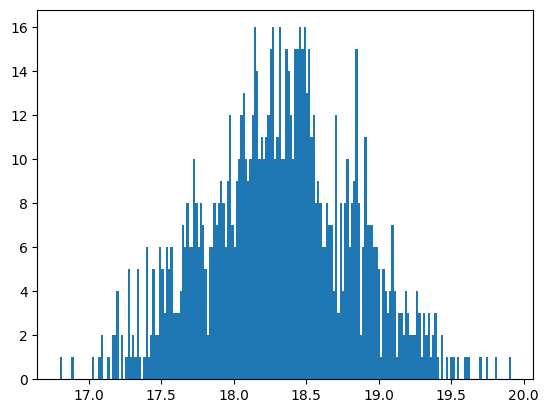



## FLOP HALVING RATE ##
{1: 1.7525436950251554,
 5: 1.9696544510531553,
 10: 2.0874718273770387,
 20: 2.2377867154066338,
 30: 2.3466280092644616,
 40: 2.4248967636924936,
 50: 2.514508086331623,
 60: 2.5906134434254366,
 70: 2.6667364241356517,
 80: 2.7592140237268685,
 90: 2.9165327118034323,
 95: 3.0306962458076994,
 99: 3.2112960827748798}


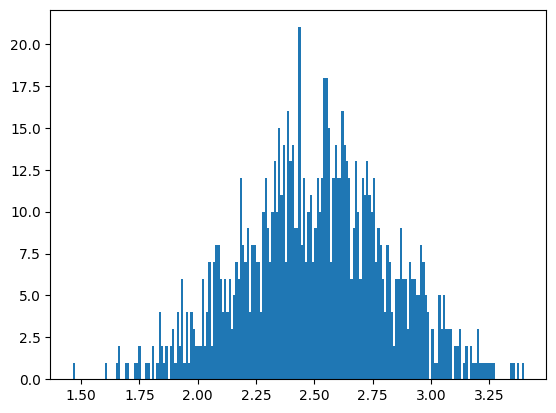



## MAX FLOP PER DOLLAR ##
{1: 20.027954040819484,
 5: 20.988258450932985,
 10: 21.5227234620412,
 20: 22.23222745699631,
 30: 22.70611337104632,
 40: 23.153668991830934,
 50: 23.550609787364593,
 60: 23.910874318269272,
 70: 24.344056981589038,
 80: 24.83082026115997,
 90: 25.519097010471913,
 95: 26.09570427083291,
 99: 26.945932749028863}


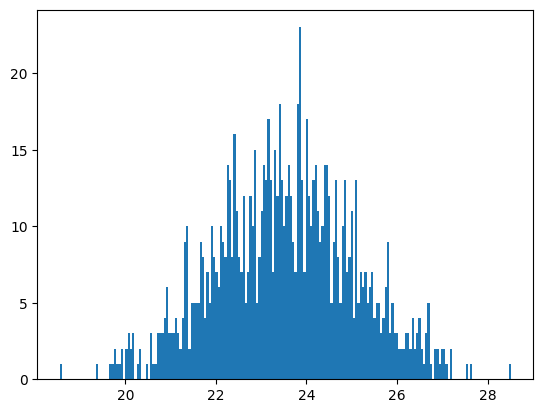



## INITIAL PAY ##
{1: 8.4,
 5: 8.7,
 10: 8.7,
 20: 8.9,
 30: 9.0,
 40: 9.1,
 50: 9.2,
 60: 9.2,
 70: 9.3,
 80: 9.5,
 90: 9.6,
 95: 9.8,
 99: 10.2}


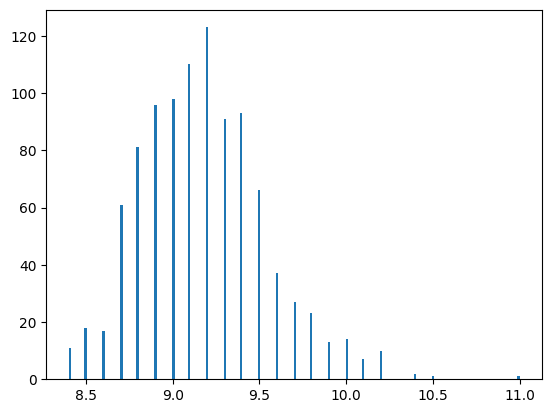



## INITIAL GDP ##
{1: 24804912203202.04,
 5: 24895335893547.555,
 10: 24940887698484.82,
 20: 25000747743590.03,
 30: 25039525724697.71,
 40: 25073348039377.715,
 50: 25106462833039.344,
 60: 25142636013081.25,
 70: 25178953651600.74,
 80: 25218012558180.02,
 90: 25277816455074.008,
 95: 25318809370832.94,
 99: 25395854373993.453}


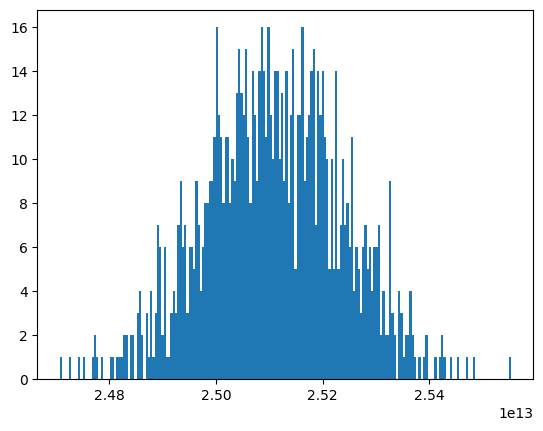



## GDP GROWTH ##
{1: 1.0052211483014535,
 5: 1.0096152540184333,
 10: 1.0128807206063541,
 20: 1.0163841791613821,
 30: 1.0185994696917857,
 40: 1.0205915461533104,
 50: 1.022418684301738,
 60: 1.023941302608941,
 70: 1.0260721992152733,
 80: 1.0281023559831781,
 90: 1.0311594953894663,
 95: 1.0338800159609987,
 99: 1.0388517617101798}


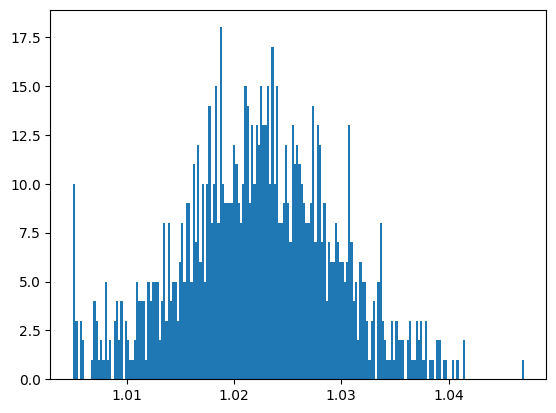



## MAX GDP FRAC ##
{1: 1.2188878096949339e-05,
 5: 2.934927616809905e-05,
 10: 5.762227010984713e-05,
 20: 0.00010923058730413082,
 30: 0.0001716421438551786,
 40: 0.0002469841679745425,
 50: 0.00035678975393392304,
 60: 0.0005143602466163642,
 70: 0.0007485220983097943,
 80: 0.0011773773265888318,
 90: 0.0021985737876033993,
 95: 0.0036335465247273927,
 99: 0.00828455852833543}


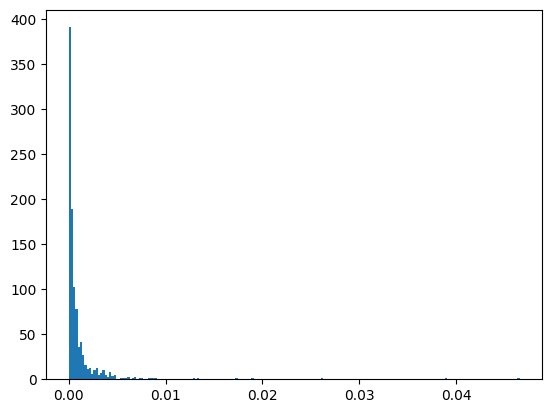



## SPEND DOUBLING TIME ##
{1: 0.40017686113138645,
 5: 0.49395558064674955,
 10: 0.5699092396788452,
 20: 0.6957000649857606,
 30: 0.7883475241752226,
 40: 0.8803646238294962,
 50: 0.9839846347802965,
 60: 1.089918748226037,
 70: 1.20745480365922,
 80: 1.3733199028787182,
 90: 1.6419618914957839,
 95: 1.9061473236738724,
 99: 2.495539205357041}


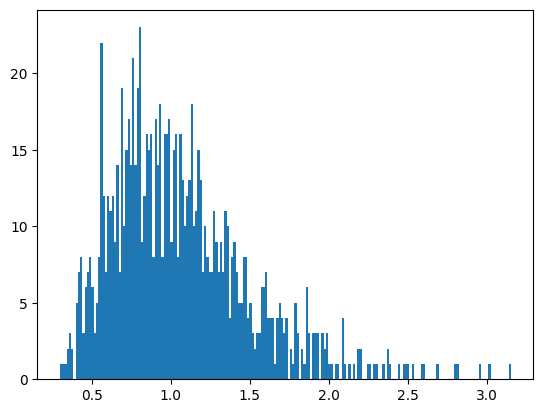





## Nonscaling delay ##
There are 3 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 1,
 5: 1,
 10: 1,
 20: 2,
 30: 2,
 40: 2,
 50: 2,
 60: 3,
 70: 3,
 80: 4,
 90: 6,
 95: 9,
 99: 16}
## Chance of nonscaling delay ##


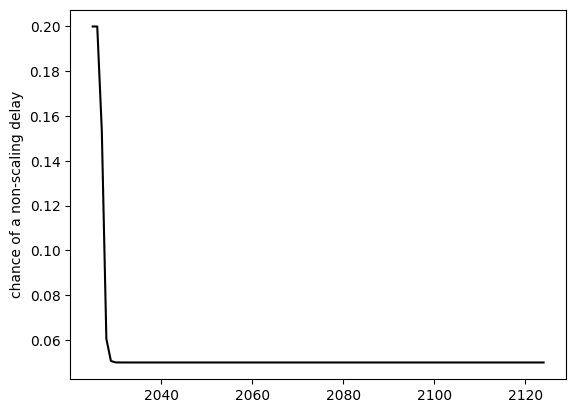

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - chan

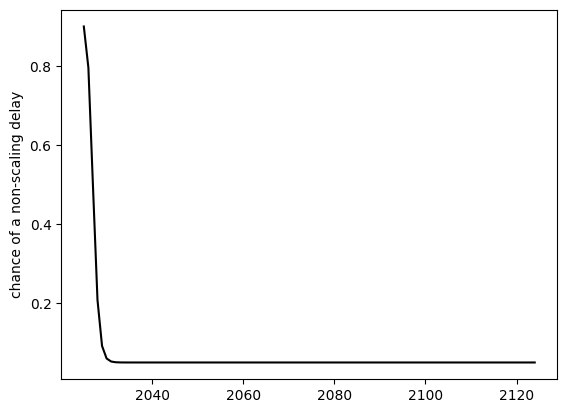

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - cha

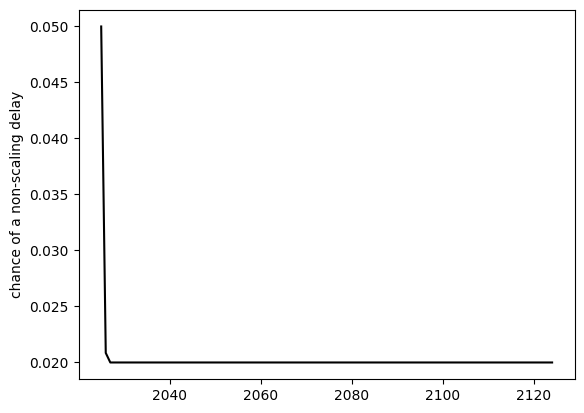

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2035 - chance 

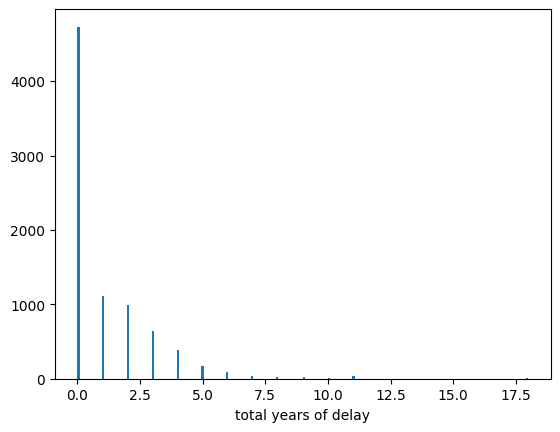

In [15]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=max(1, os.cpu_count() - 2),
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 26.9 log FLOP (~794.3 septillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.5 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 26.8 log FLOP (~616.8 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~421.7 million).
* This doubles every 0.8 year to a max of 0.005082% of GDP (initially ~1.3 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 26.9 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 8.5 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 3

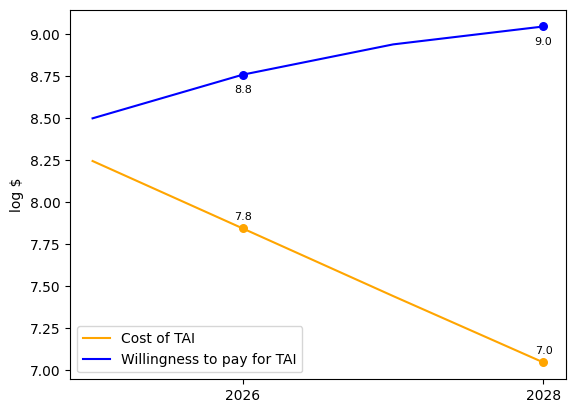

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 31.5 log FLOP (~31.6 nonillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~488.9 quadrillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~431.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~455.6 million).
* This doubles every 0.6 year to a max of 0.006557% of GDP (initially ~1.6 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 31.5 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 8.6 (buys 26.2 log FLOP or 26.2 2025-log-eFLOP)
2026 - TAI takes 31.3 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 8.9 (buys 26.7 log FLOP or 26.9 2025-log-eFLOP)
2027 - TAI takes 31.1 logFLOP which costs 13.2 log 2025$USD to buy vs. WTP at 9.1 (buys 27.0 log FLOP or 27.4 2025-log-eFLOP)
2028 - TAI takes 30.9 logFLOP which cos

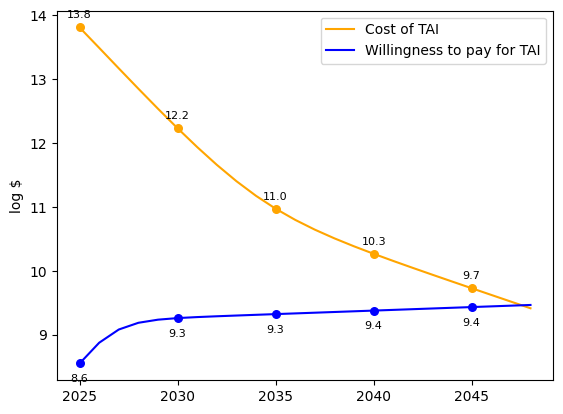

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 27.3 log FLOP (~2.0 octillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~879.1 million).
* This doubles every 1.2 year to a max of 0.006179% of GDP (initially ~1.6 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 27.3 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 8.8 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 27.1 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.9 (buys 27.4 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.796 -> Nonscaling delay occured
-- -- this delay is 3 years (total 

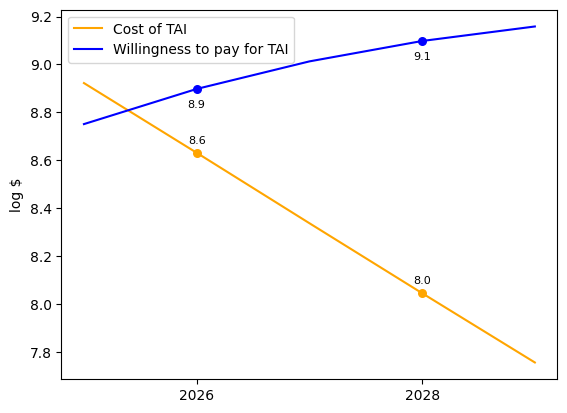

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 38.3 log FLOP (~199.5 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~583.4 quadrillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~11.5 septillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~2.2 billion).
* This doubles every 1.4 year to a max of 0.019285% of GDP (initially ~4.8 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 38.3 logFLOP which costs 20.5 log 2025$USD to buy vs. WTP at 9.2 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 37.9 logFLOP which costs 20.0 log 2025$USD to buy vs. WTP at 9.3 (buys 27.2 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 37.5 logFLOP which costs 19.4 log 2025$USD to buy vs. WTP at 9.4 (buys 27.5 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 37.1 logFLOP wh

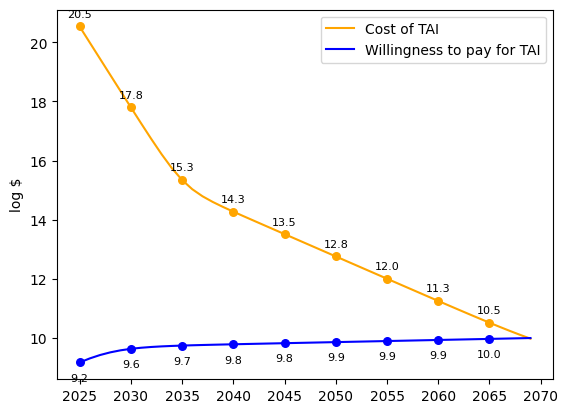

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 26.7 log FLOP (~501.2 septillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~182.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~501.6 million).
* This doubles every 1.0 year to a max of 0.005414% of GDP (initially ~1.4 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 26.7 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.6 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 26.5 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 8.8 (buys 27.0 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.796 -> Nonscaling delay occured
-- -- this delay is 4 years (t

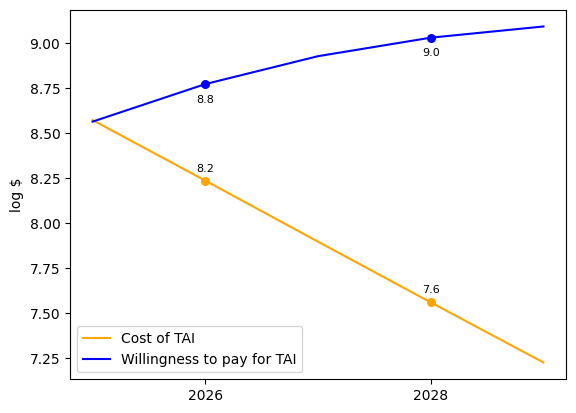

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 44.3 log FLOP (~199.5 billion decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.9 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~43.6 septillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.9 billion).
* This doubles every 1.0 year to a max of 0.031842% of GDP (initially ~8.0 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 44.3 logFLOP which costs 26.0 log 2025$USD to buy vs. WTP at 9.2 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 44.1 logFLOP which costs 25.7 log 2025$USD to buy vs. WTP at 9.4 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 43.9 logFLOP which costs 25.3 log 2025$USD to buy vs. WTP at 9.6 (buys 28.1 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 43.6 logFLOP which

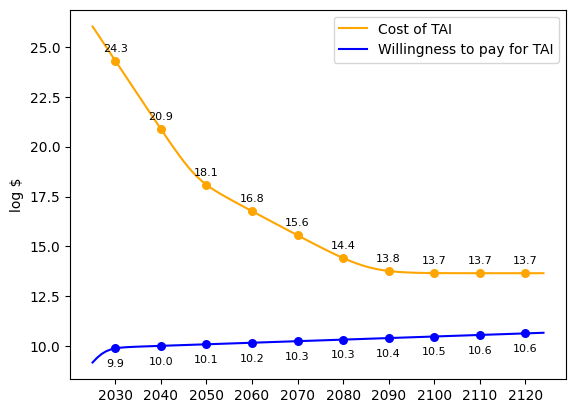

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 26.4 log FLOP (~251.2 septillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~718.1 quadrillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.3 septillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~4.5 billion).
* This doubles every 0.8 year to a max of 0.172924% of GDP (initially ~43.6 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 26.4 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 9.6 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 4

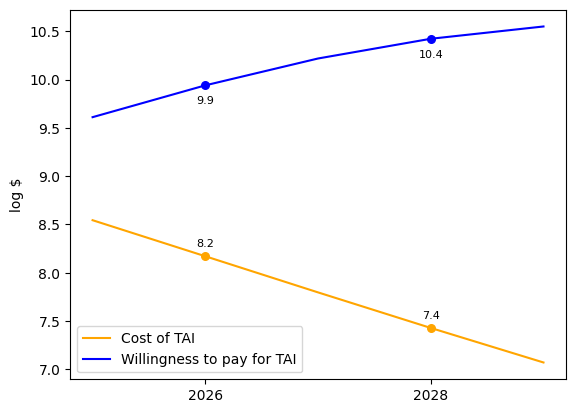

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 34.6 log FLOP (~39.8 decillion) for transformative capabilities.
* Every 0.4 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.7 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~191.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~789.4 million).
* This doubles every 1.3 year to a max of 0.513037% of GDP (initially ~127.9 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 34.6 logFLOP which costs 16.2 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 33.8 logFLOP which costs 15.2 log 2025$USD to buy vs. WTP at 9.1 (buys 27.7 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 33.0 logFLOP which costs 14.3 log 2025$USD to buy vs. WTP at 9.3 (buys 28.0 log FLOP or 29.6 2025-log-eFLOP)
2028 - TAI takes 32.3 logFLOP which co

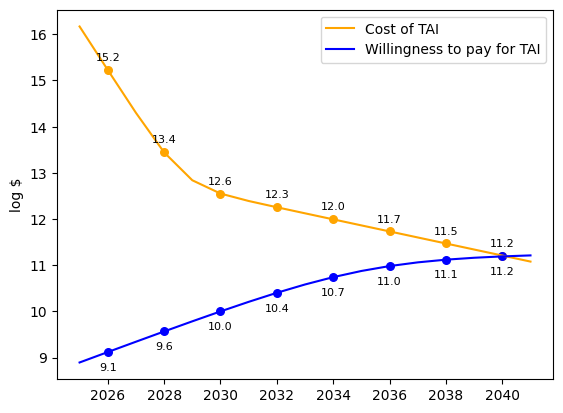

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 36.8 log FLOP (~6.3 thousand decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~934.0 quadrillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~217.2 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.4 billion).
* This doubles every 0.8 year to a max of 0.243737% of GDP (initially ~61.2 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 36.8 logFLOP which costs 18.8 log 2025$USD to buy vs. WTP at 9.4 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 36.4 logFLOP which costs 18.3 log 2025$USD to buy vs. WTP at 9.7 (buys 27.8 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 35.9 logFLOP which costs 17.7 log 2025$USD to buy vs. WTP at 10.1 (buys 28.3 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 35.5 logFLOP 

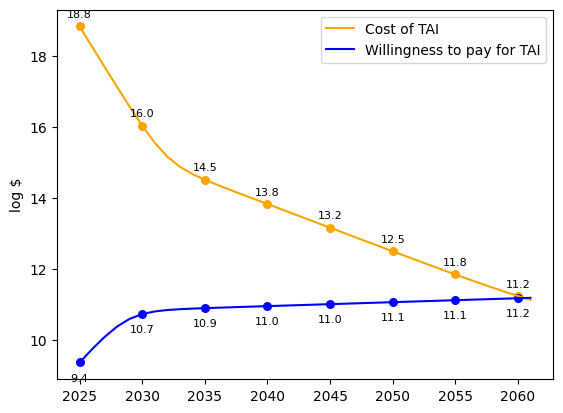

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 30.7 log FLOP (~5.0 nonillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 20.0 log FLOP (~101.7 quintillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.9 year to a max of 0.082556% of GDP (initially ~20.8 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 30.7 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 9.1 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 30.5 logFLOP which costs 12.1 log 2025$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 30.4 logFLOP which costs 11.8 log 2025$USD to buy vs. WTP at 9.3 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 30.2 logFLOP which costs

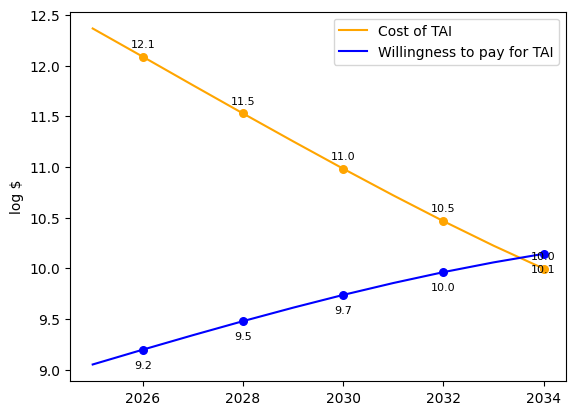

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 34.4 log FLOP (~25.1 decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~769.5 quadrillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~792.3 million).
* This doubles every 2.1 year to a max of 1.214699% of GDP (initially ~304.1 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 34.4 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 8.9 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 34.1 logFLOP which costs 16.1 log 2025$USD to buy vs. WTP at 9.0 (buys 27.1 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 33.8 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 9.2 (buys 27.3 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 33.5 logFLOP which co

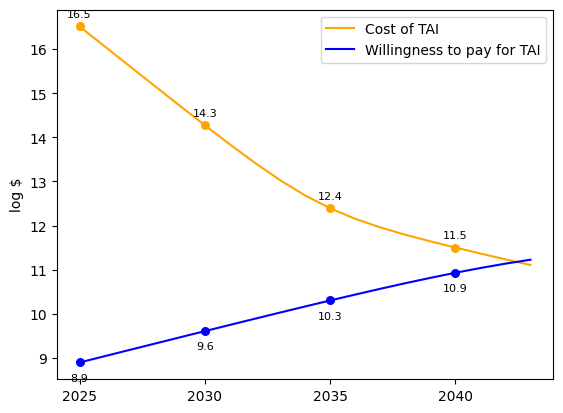

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 31.2 log FLOP (~15.8 nonillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.7 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~16.2 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.9 billion).
* This doubles every 0.7 year to a max of 0.290418% of GDP (initially ~73.3 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 31.2 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 9.3 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 30.8 logFLOP which costs 12.0 log 2025$USD to buy vs. WTP at 9.7 (buys 28.5 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 30.4 logFLOP which costs 11.5 log 2025$USD to buy vs. WTP at 10.1 (buys 29.0 log FLOP or 29.8 2025-log-eFLOP)
2028 - TAI takes 30.1 logFLOP which costs

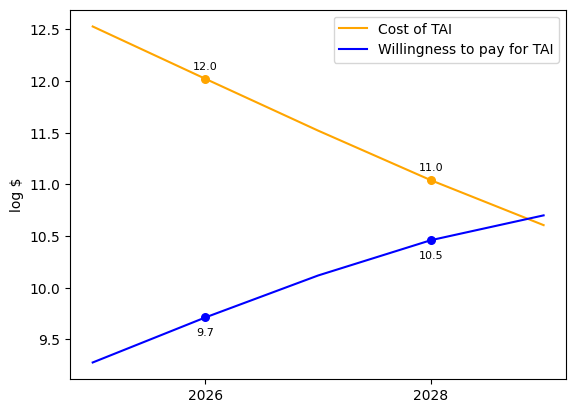

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 32.4 log FLOP (~251.2 nonillion) for transformative capabilities.
* Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.9 billion).
* This doubles every 1.2 year to a max of 0.246731% of GDP (initially ~61.9 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 32.4 logFLOP which costs 14.0 log 2025$USD to buy vs. WTP at 9.3 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 32.3 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 9.5 (buys 28.0 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 32.2 logFLOP which costs 13.6 log 2025$USD to buy vs. WTP at 9.7 (buys 28.3 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 32.1 logFLOP which costs 

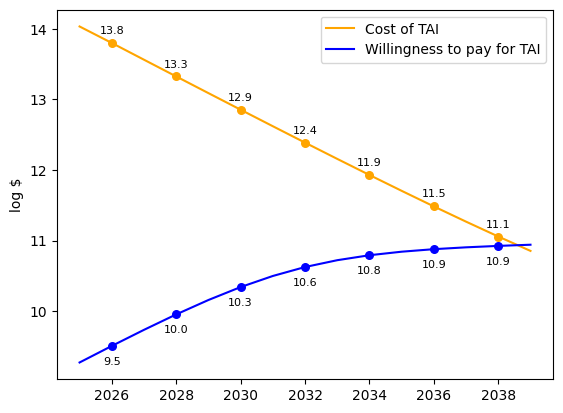

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 26.3 log FLOP (~199.5 septillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~745.9 quadrillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~124.9 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 0.6 year to a max of 0.288099% of GDP (initially ~72.4 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 26.3 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 9.1 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 

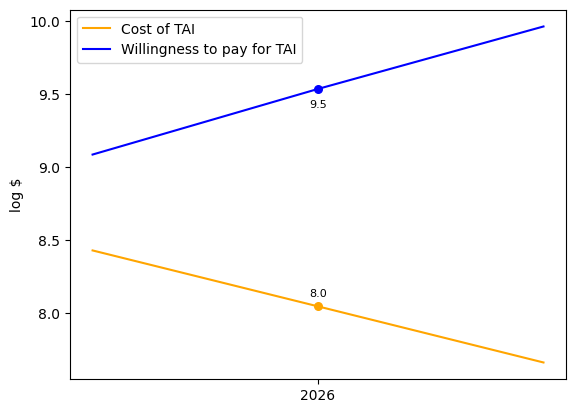

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~459.8 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~35.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~964.1 million).
* This doubles every 0.8 year to a max of 0.107316% of GDP (initially ~26.9 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 27.6 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 9.0 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 27.5 logFLOP which costs 9.7 log 2025$USD to buy vs. WTP at 9.3 (buys 27.1 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 27.4 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 9.7 (buys 27.6 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1535 

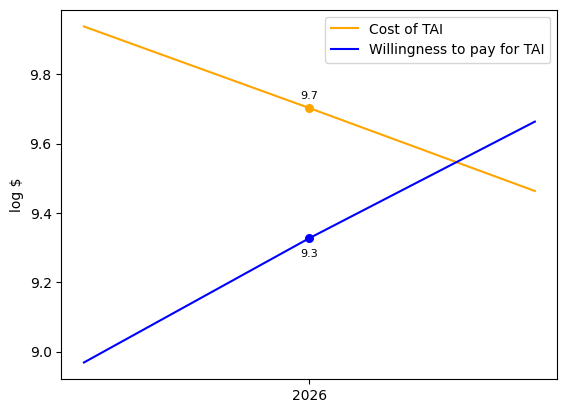

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~44.5 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~923.9 million).
* This doubles every 1.6 year to a max of 0.048404% of GDP (initially ~12.1 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 8.9 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 2

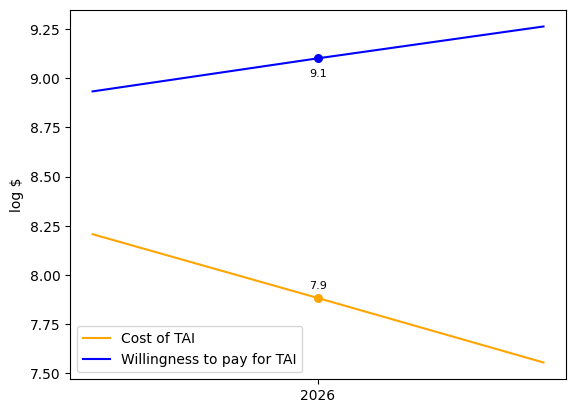

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 34.4 log FLOP (~25.1 decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~17.6 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~24.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~909.6 million).
* This doubles every 1.3 year to a max of 0.040258% of GDP (initially ~10.1 billion 2025$USD).
* GDP grows at a rate of 1.011x per year.
---
2025 - TAI takes 34.4 logFLOP which costs 15.2 log 2025$USD to buy vs. WTP at 8.9 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 34.1 logFLOP which costs 14.7 log 2025$USD to buy vs. WTP at 9.1 (buys 28.5 log FLOP or 28.8 2025-log-eFLOP)
2027 - TAI takes 33.7 logFLOP which costs 14.3 log 2025$USD to buy vs. WTP at 9.3 (buys 28.8 log FLOP or 29.5 2025-log-eFLOP)
2028 - TAI takes 33.4 logFLOP which cos

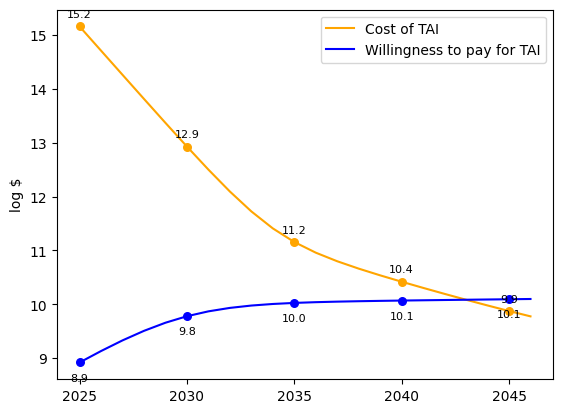

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 36.7 log FLOP (~5.0 thousand decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.6 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~6.7 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~990.6 million).
* This doubles every 1.7 year to a max of 0.018299% of GDP (initially ~4.6 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 36.7 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 8.9 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 36.1 logFLOP which costs 17.3 log 2025$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 35.6 logFLOP which costs 16.6 log 2025$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 29.3 2025-log-eFLOP)
2028 - TAI takes 35.0 logFLOP whic

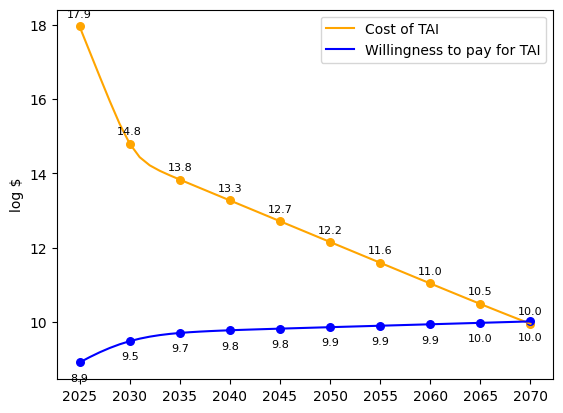

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 34.3 log FLOP (~20.0 decillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.7 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 20.2 log FLOP (~164.7 quintillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~247.4 million).
* This doubles every 0.7 year to a max of 0.001632% of GDP (initially ~407.1 million 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 34.3 logFLOP which costs 15.9 log 2025$USD to buy vs. WTP at 8.2 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 34.1 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 8.4 (buys 27.0 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 33.9 logFLOP which costs 15.2 log 2025$USD to buy vs. WTP at 8.5 (buys 27.2 log FLOP or 27.6 2025-log-eFLOP)
2028 - TAI takes 33.7 logFLOP which c

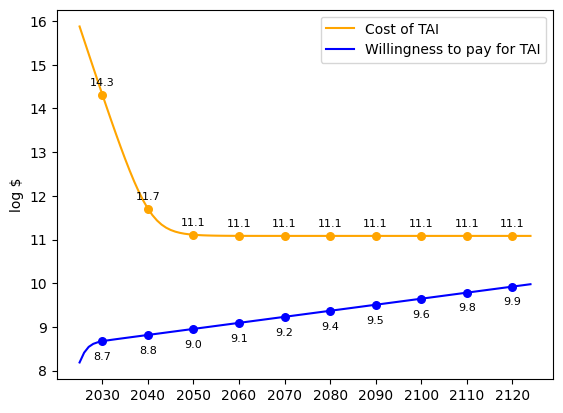

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 30.9 log FLOP (~7.9 nonillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~670.4 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~3.9 septillion) per 2025$USD.
* We are initially willing to pay 10.6 log 2025$USD (~40.6 billion).
* This doubles every 2.4 year to a max of 0.239133% of GDP (initially ~60.0 billion 2025$USD).
* GDP grows at a rate of 1.011x per year.
---
2025 - TAI takes 30.9 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 10.4 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 30.8 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 10.5 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 30.6 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 10.5 (buys 28.6 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 30.5 logFLOP which c

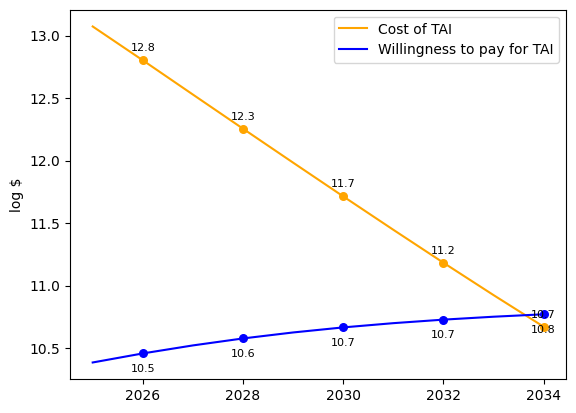

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 27.3 log FLOP (~2.0 octillion) for transformative capabilities.
* Every 3.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~840.9 quadrillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.0 billion).
* This doubles every 0.6 year to a max of 0.321367% of GDP (initially ~81.1 billion 2025$USD).
* GDP grows at a rate of 1.047x per year.
---
2025 - TAI takes 27.3 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 9.5 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 2 m

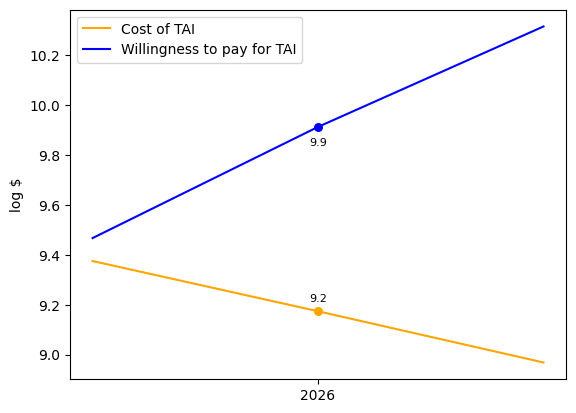

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 31.3 log FLOP (~20.0 nonillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~470.1 quadrillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~8.5 septillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.0 billion).
* This doubles every 0.9 year to a max of 0.22962% of GDP (initially ~57.6 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 31.3 logFLOP which costs 13.6 log 2025$USD to buy vs. WTP at 9.5 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 31.1 logFLOP which costs 13.3 log 2025$USD to buy vs. WTP at 9.8 (buys 27.6 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 31.0 logFLOP which costs 13.0 log 2025$USD to buy vs. WTP at 10.1 (buys 28.0 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 30.8 logFLOP which costs

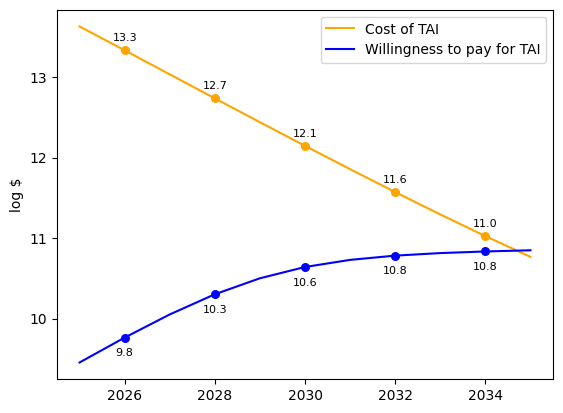

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 39.1 log FLOP (~1.3 million decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 3.6 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~969.4 quadrillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.1 billion).
* This doubles every 2.4 year to a max of 0.412038% of GDP (initially ~103.1 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 39.1 logFLOP which costs 21.1 log 2025$USD to buy vs. WTP at 9.5 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 38.8 logFLOP which costs 20.7 log 2025$USD to buy vs. WTP at 9.6 (buys 27.7 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 38.6 logFLOP which costs 20.4 log 2025$USD to buy vs. WTP at 9.7 (buys 27.9 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 38.3 logFLOP 

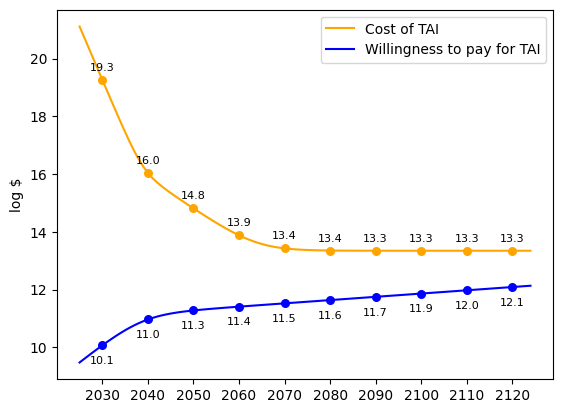

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 25.6 log FLOP (~39.8 septillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~887.7 quadrillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~555.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.1 billion).
* This doubles every 1.8 year to a max of 0.042175% of GDP (initially ~10.6 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 25.6 logFLOP which costs 7.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 

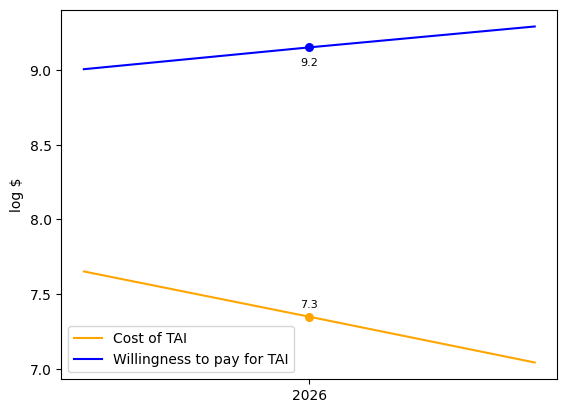

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 27.2 log FLOP (~1.6 octillion) for transformative capabilities.
* Every 3.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.8 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~99.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.5 billion).
* This doubles every 0.9 year to a max of 0.551924% of GDP (initially ~139.5 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 27.2 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 9.4 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 3 mor

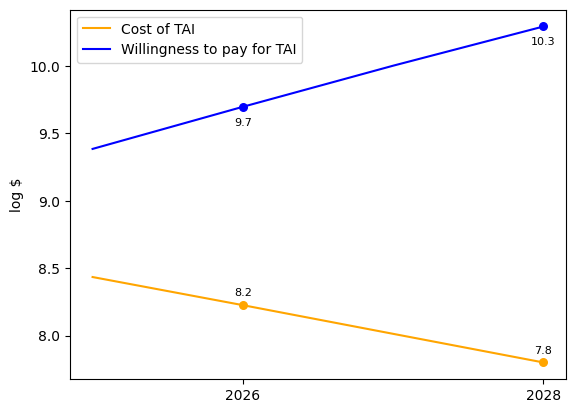

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 31.5 log FLOP (~31.6 nonillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 20.1 log FLOP (~114.9 quintillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~765.0 million).
* This doubles every 1.0 year to a max of 0.083128% of GDP (initially ~20.7 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 31.5 logFLOP which costs 13.2 log 2025$USD to buy vs. WTP at 8.9 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 31.4 logFLOP which costs 13.0 log 2025$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 31.2 logFLOP which costs 12.7 log 2025$USD to buy vs. WTP at 9.4 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 31.1 logFLOP which co

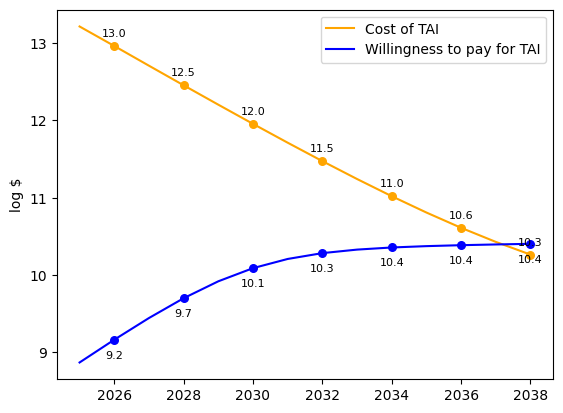

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 28.7 log FLOP (~50.1 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.5 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~28.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.0 billion).
* This doubles every 1.0 year to a max of 0.029781% of GDP (initially ~7.4 billion 2025$USD).
* GDP grows at a rate of 1.01x per year.
---
2025 - TAI takes 28.7 logFLOP which costs 10.2 log 2025$USD to buy vs. WTP at 9.3 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 28.5 logFLOP which costs 9.8 log 2025$USD to buy vs. WTP at 9.5 (buys 28.2 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 28.2 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 9.7 (buys 28.4 log FLOP or 28.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1535 -> N

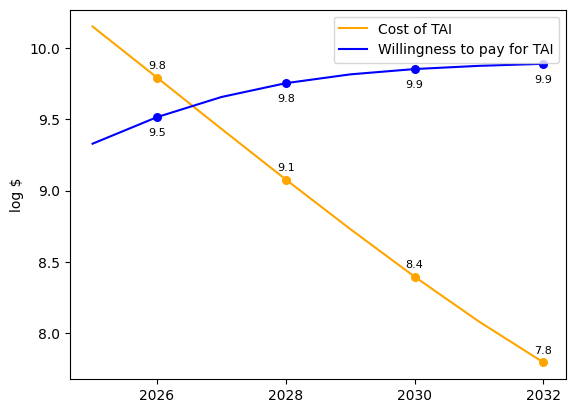

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 32.0 log FLOP (~100.0 nonillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~43.6 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.3 billion).
* This doubles every 0.8 year to a max of 0.015319% of GDP (initially ~3.9 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 32.0 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 9.0 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 31.9 logFLOP which costs 13.6 log 2025$USD to buy vs. WTP at 9.2 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 31.7 logFLOP which costs 13.3 log 2025$USD to buy vs. WTP at 9.4 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 31.6 logFLOP which costs 

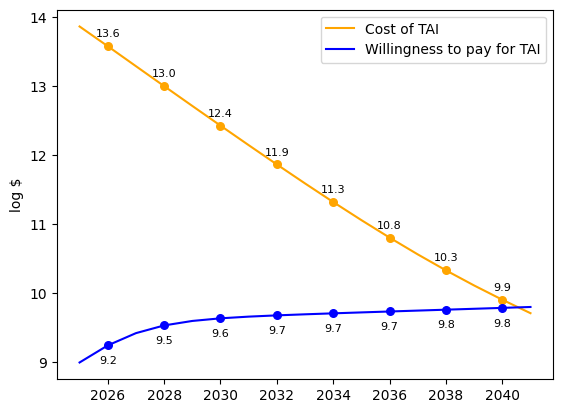

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 33.6 log FLOP (~4.0 decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.0 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.2 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~531.0 million).
* This doubles every 1.3 year to a max of 0.013383% of GDP (initially ~3.4 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 33.6 logFLOP which costs 15.0 log 2025$USD to buy vs. WTP at 8.7 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 33.1 logFLOP which costs 14.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 32.5 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 32.1 logFLOP which costs 1

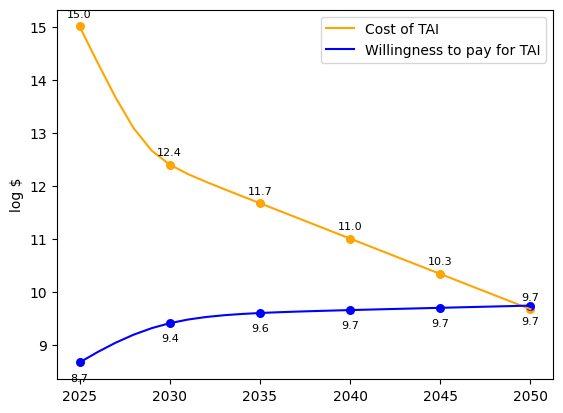

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 42.1 log FLOP (~1.3 billion decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 19.6 log FLOP (~40.1 quintillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 0.8 year to a max of 0.019617% of GDP (initially ~4.9 billion 2025$USD).
* GDP grows at a rate of 1.011x per year.
---
2025 - TAI takes 42.1 logFLOP which costs 23.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.4 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 41.7 logFLOP which costs 23.2 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 41.4 logFLOP which costs 22.7 log 2025$USD to buy vs. WTP at 9.4 (buys 28.1 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 41.0 logFLOP which

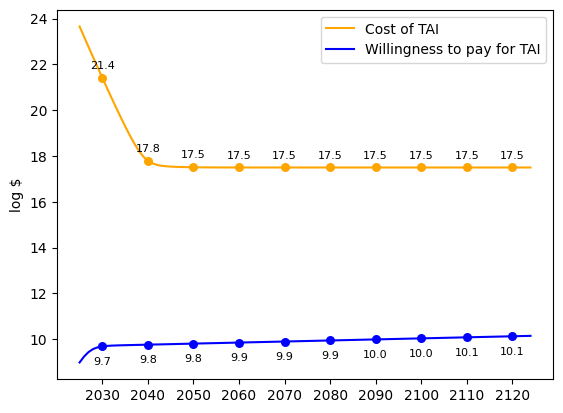

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 30.1 log FLOP (~1.3 nonillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.1 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~18.2 sextillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.5 billion).
* This doubles every 1.1 year to a max of 0.021496% of GDP (initially ~5.4 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 30.1 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 9.3 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 29.8 logFLOP which costs 11.0 log 2025$USD to buy vs. WTP at 9.5 (buys 28.3 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 29.6 logFLOP which costs 10.6 log 2025$USD to buy vs. WTP at 9.6 (buys 28.6 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 29.3 logFLOP which costs 10.

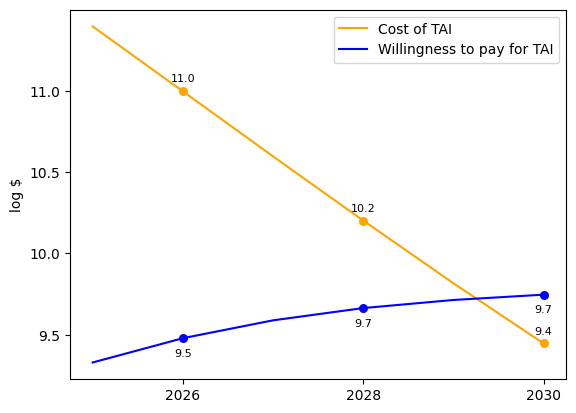

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 31.6 log FLOP (~39.8 nonillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.4 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~5.7 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.1 billion).
* This doubles every 0.6 year to a max of 0.028453% of GDP (initially ~7.1 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 31.6 logFLOP which costs 12.9 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 31.2 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 9.4 (buys 28.2 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 30.8 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 9.7 (buys 28.7 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 30.5 logFLOP which costs 11.

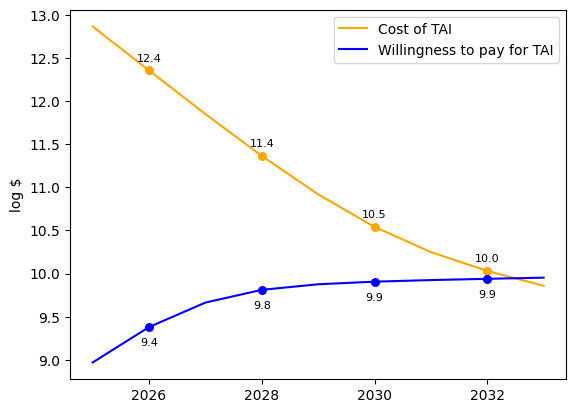

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 52.4 log FLOP (~25.1 quintillion decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 7 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.4 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~91.3 septillion) per 2025$USD.
* We are initially willing to pay 10.1 log 2025$USD (~12.8 billion).
* This doubles every 1.1 year to a max of 0.267777% of GDP (initially ~67.6 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 52.4 logFLOP which costs 33.8 log 2025$USD to buy vs. WTP at 10.0 (buys 28.7 log FLOP or 28.7 2025-log-eFLOP)
2026 - TAI takes 52.1 logFLOP which costs 33.4 log 2025$USD to buy vs. WTP at 10.3 (buys 29.0 log FLOP or 29.3 2025-log-eFLOP)
2027 - TAI takes 51.9 logFLOP which costs 33.0 log 2025$USD to buy vs. WTP at 10.4 (buys 29.4 log FLOP or 29.9 2025-log-eFLOP)
2028 - TAI takes 51.6 log

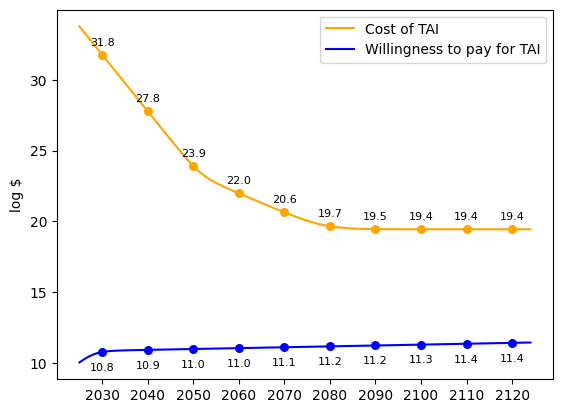

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 26.7 log FLOP (~501.2 septillion) for transformative capabilities.
* Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.6 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.2 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~986.9 million).
* This doubles every 1.3 year to a max of 0.29851% of GDP (initially ~75.1 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 26.7 logFLOP which costs 8.1 log 2025$USD to buy vs. WTP at 9.0 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 2 m

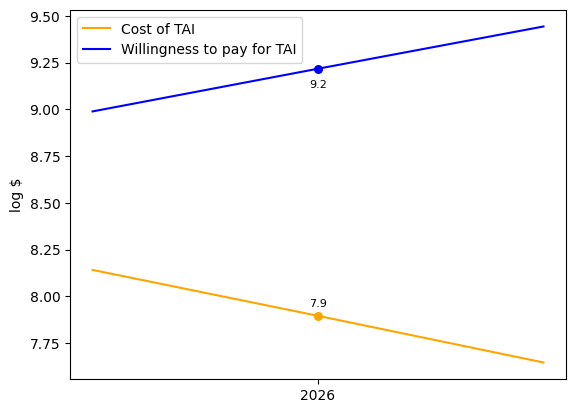

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 26.8 log FLOP (~631.0 septillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.7 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~261.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~460.5 million).
* This doubles every 1.9 year to a max of 0.022697% of GDP (initially ~5.7 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 26.8 logFLOP which costs 8.1 log 2025$USD to buy vs. WTP at 8.6 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
--- /!\ TAI CREATED in 2025
-
-
## SAMPLE RUN 39 ##

In this simulation:
* It take

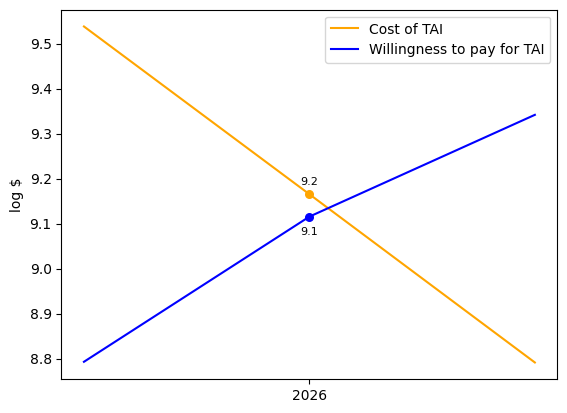

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 27.3 log FLOP (~2.0 octillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~63.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~3.6 billion).
* This doubles every 1.7 year to a max of 0.049118% of GDP (initially ~12.4 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 27.3 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 9.4 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
--- /!\ TAI CREATED in 2025
-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 44.

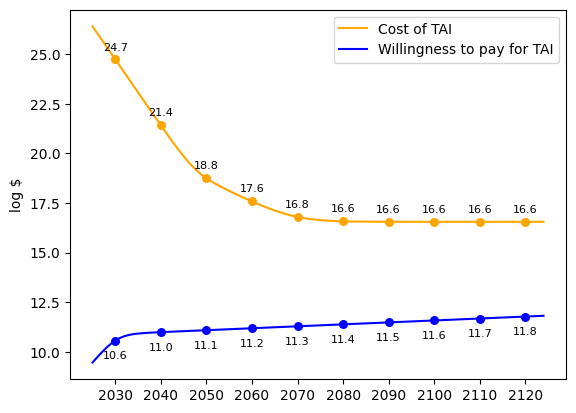

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 28.8 log FLOP (~63.1 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.9 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~26.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~4.8 billion).
* This doubles every 1.1 year to a max of 0.030721% of GDP (initially ~7.6 billion 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 28.8 logFLOP which costs 10.0 log 2025$USD to buy vs. WTP at 9.5 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 28.5 logFLOP which costs 9.6 log 2025$USD to buy vs. WTP at 9.6 (buys 28.5 log FLOP or 28.8 2025-log-eFLOP)
2027 - TAI takes 28.2 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 9.7 (buys 28.7 log FLOP or 29.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1535 -> 

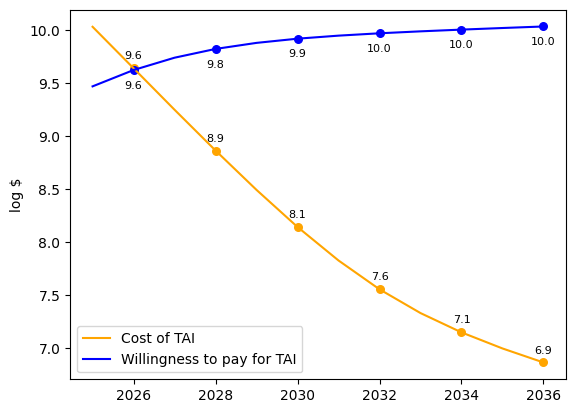

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 27.0 log FLOP (~1.0 octillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.2 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.1 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.3 billion).
* This doubles every 1.2 year to a max of 0.14305% of GDP (initially ~36.1 billion 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 27.0 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 9.3 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 4 more 

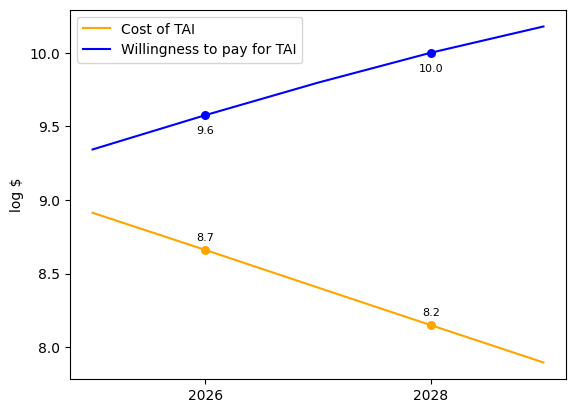

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 29.1 log FLOP (~125.9 octillion) for transformative capabilities.
* Every 2.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.2 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~36.9 sextillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~4.5 billion).
* This doubles every 1.0 year to a max of 0.041004% of GDP (initially ~10.4 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 29.1 logFLOP which costs 10.5 log 2025$USD to buy vs. WTP at 9.5 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 29.0 logFLOP which costs 10.2 log 2025$USD to buy vs. WTP at 9.7 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 28.8 logFLOP which costs 10.0 log 2025$USD to buy vs. WTP at 9.8 (buys 28.7 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 28.7 logFLOP which costs

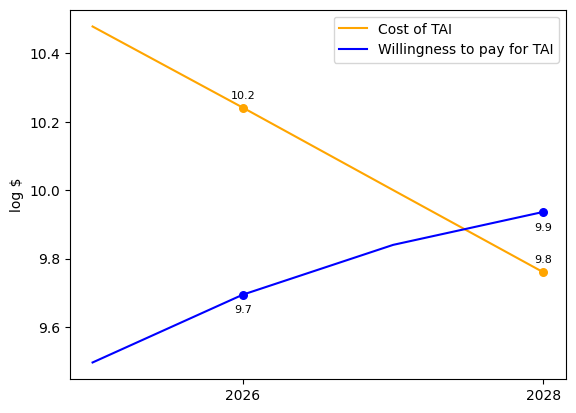

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 43.5 log FLOP (~31.6 billion decillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~653.0 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 26.3 log FLOP (~190.8 septillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.1 billion).
* This doubles every 2.2 year to a max of 0.053361% of GDP (initially ~13.4 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 43.5 logFLOP which costs 25.7 log 2025$USD to buy vs. WTP at 9.4 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 43.3 logFLOP which costs 25.4 log 2025$USD to buy vs. WTP at 9.5 (buys 27.4 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 43.2 logFLOP which costs 25.1 log 2025$USD to buy vs. WTP at 9.6 (buys 27.7 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 43.0 logFLOP w

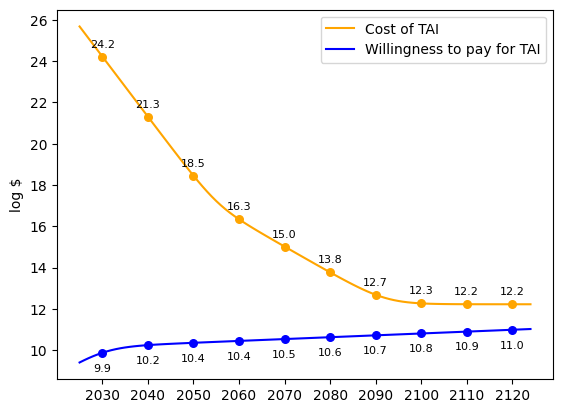

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 24.7 log FLOP (~5.0 septillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.0 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 26.9 log FLOP (~801.5 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~835.2 million).
* This doubles every 1.3 year to a max of 0.020278% of GDP (initially ~5.1 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 24.7 logFLOP which costs 6.7 log 2025$USD to buy vs. WTP at 8.9 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 4 m

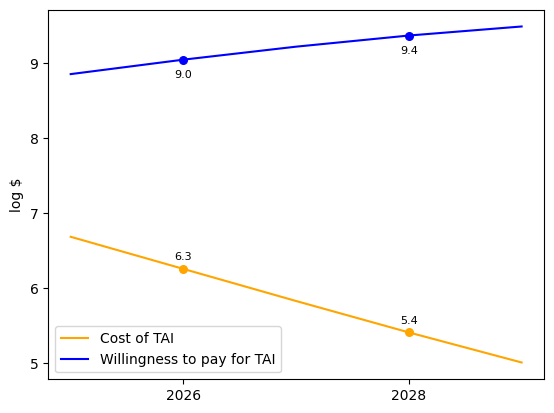

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 25.0 log FLOP (~10.0 septillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.1 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 0.7 year to a max of 0.229566% of GDP (initially ~57.4 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 25.0 logFLOP which costs 6.9 log 2025$USD to buy vs. WTP at 9.1 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 2 mo

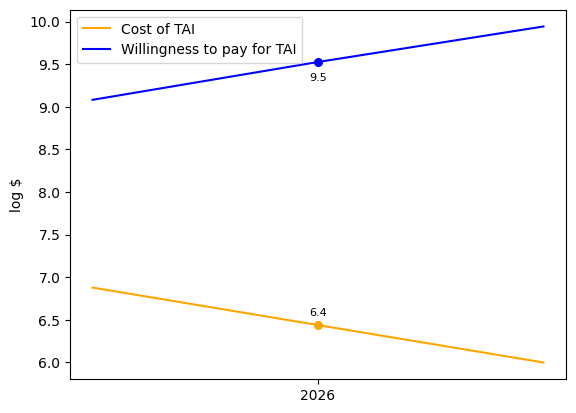

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 36.2 log FLOP (~1.6 thousand decillion) for transformative capabilities.
* Every 2.3 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.8 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~8.5 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.3 billion).
* This doubles every 0.6 year to a max of 0.024244% of GDP (initially ~6.1 billion 2025$USD).
* GDP grows at a rate of 1.036x per year.
---
2025 - TAI takes 36.2 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 36.1 logFLOP which costs 17.7 log 2025$USD to buy vs. WTP at 9.4 (buys 27.7 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 35.9 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 9.6 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 35.8 logFLOP which 

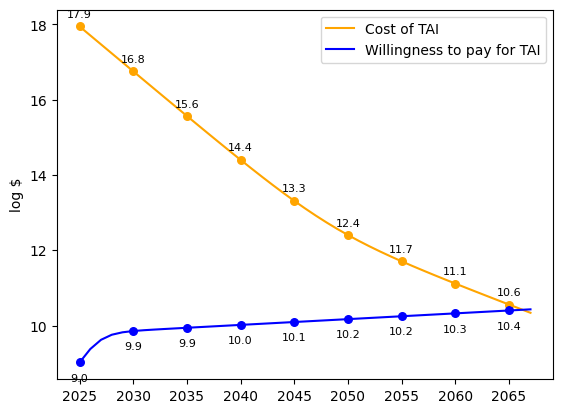

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 37.8 log FLOP (~63.1 thousand decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.8 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.3 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~784.1 million).
* This doubles every 0.8 year to a max of 0.242123% of GDP (initially ~60.7 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 37.8 logFLOP which costs 19.1 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 37.5 logFLOP which costs 18.7 log 2025$USD to buy vs. WTP at 9.3 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 37.1 logFLOP which costs 18.2 log 2025$USD to buy vs. WTP at 9.6 (buys 28.6 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 36.8 logFLOP whi

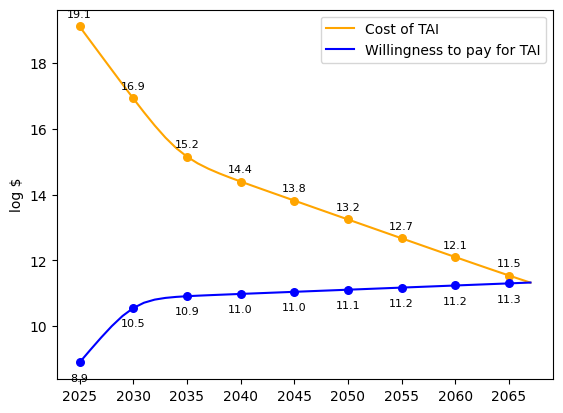

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 29.1 log FLOP (~125.9 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.1 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.2 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~716.1 million).
* This doubles every 0.9 year to a max of 0.028707% of GDP (initially ~7.3 billion 2025$USD).
* GDP grows at a rate of 1.011x per year.
---
2025 - TAI takes 29.1 logFLOP which costs 10.6 log 2025$USD to buy vs. WTP at 8.8 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 28.9 logFLOP which costs 10.2 log 2025$USD to buy vs. WTP at 9.1 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 28.7 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 9.4 (buys 28.2 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 28.5 logFLOP which costs 

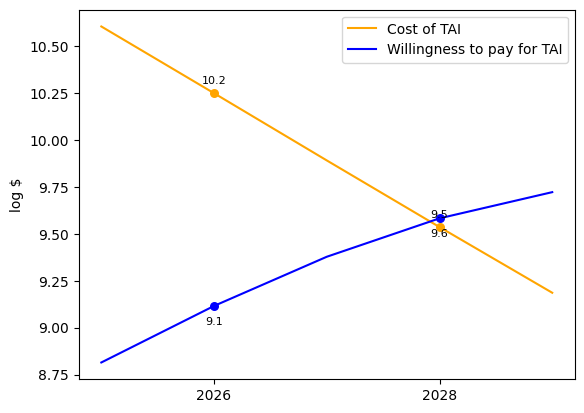

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 42.4 log FLOP (~2.5 billion decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 3.8 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.0 quintillion) per 2025$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~809.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 1.1 year to a max of 0.117769% of GDP (initially ~29.5 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 42.4 logFLOP which costs 23.3 log 2025$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 41.9 logFLOP which costs 22.7 log 2025$USD to buy vs. WTP at 9.4 (buys 28.7 log FLOP or 29.1 2025-log-eFLOP)
2027 - TAI takes 41.5 logFLOP which costs 22.1 log 2025$USD to buy vs. WTP at 9.7 (buys 29.1 log FLOP or 30.0 2025-log-eFLOP)
2028 - TAI takes 41.0 logFLOP w

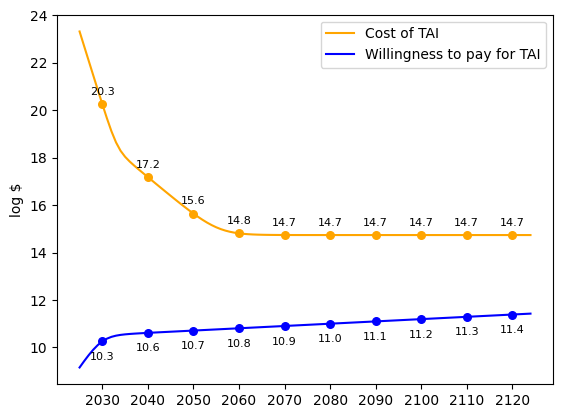

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 30.7 log FLOP (~5.0 nonillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.2 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.5 log FLOP (~33.2 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~899.2 million).
* This doubles every 1.2 year to a max of 0.035376% of GDP (initially ~8.9 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 30.7 logFLOP which costs 12.6 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 30.5 logFLOP which costs 12.3 log 2025$USD to buy vs. WTP at 9.1 (buys 27.3 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 30.3 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 9.3 (buys 27.7 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 30.1 logFLOP which costs 

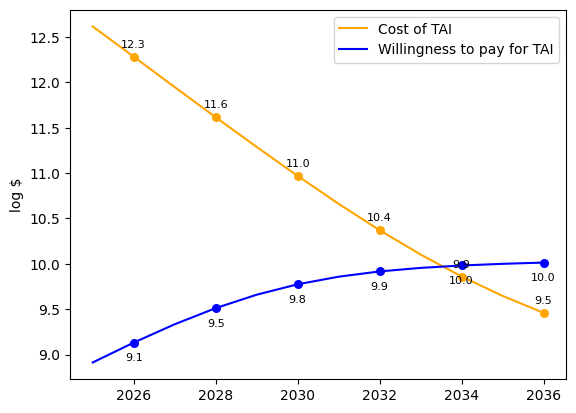

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 2.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.1 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~465.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~912.1 million).
* This doubles every 1.6 year to a max of 0.013159% of GDP (initially ~3.3 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 8.9 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 3 years)
-- data p_nonscaling_issue p=0.05 -> Nonscaling issue did not 

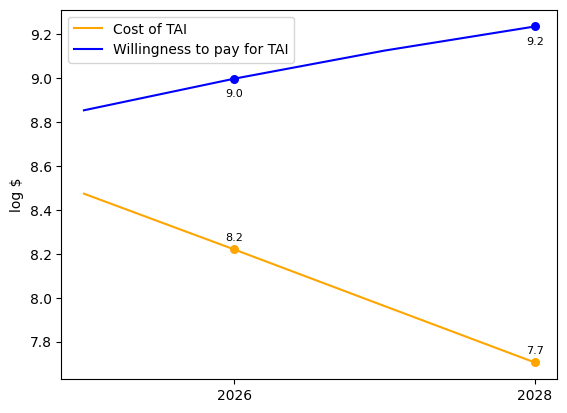

In [16]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [17]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2025-03-28 15:51:22.515609
